In [1]:
# encoding=utf8  
import numpy as np
import tensorflow as tf

def unpickle(file):
  import _pickle as cPickle
  fo = open(file, 'rb')
  dict = cPickle.load(fo,encoding='latin1')
  fo.close()
  if 'data' in dict:
    dict['data'] = dict['data'].reshape((-1, 3, 32, 32)).swapaxes(1, 3).swapaxes(1, 2).reshape(-1, 32*32*3) / 256.

  return dict

In [2]:
def load_data_one(f):
  batch = unpickle(f)
  data = batch['data']
  labels = batch['labels']
  print ("Loading %s: %d" % (f, len(data)))
  return data, labels


In [3]:

def load_data(files, data_dir, label_count):
  data, labels = load_data_one(data_dir + '/' + files[0])
  for f in files[1:]:
    data_n, labels_n = load_data_one(data_dir + '/' + f)
    data = np.append(data, data_n, axis=0)
    labels = np.append(labels, labels_n, axis=0)
  labels = np.array([ [ float(i == label) for i in range(label_count) ] for label in labels ])
  return data, labels

In [4]:
def run_in_batch_avg(session, tensors, batch_placeholders, feed_dict={}, batch_size=200):                              
  res = [ 0 ] * len(tensors)                                                                                           
  batch_tensors = [ (placeholder, feed_dict[ placeholder ]) for placeholder in batch_placeholders ]                    
  total_size = len(batch_tensors[0][1])                                                                                
  batch_count = (total_size + batch_size - 1) / batch_size                                                             
  for batch_idx in range(batch_count):                                                                                
    current_batch_size = None                                                                                          
    for (placeholder, tensor) in batch_tensors:                                                                        
      batch_tensor = tensor[ batch_idx*batch_size : (batch_idx+1)*batch_size ]                                         
      current_batch_size = len(batch_tensor)                                                                           
      feed_dict[placeholder] = tensor[ batch_idx*batch_size : (batch_idx+1)*batch_size ]                               
    tmp = session.run(tensors, feed_dict=feed_dict)                                                                    
    res = [ r + t * current_batch_size for (r, t) in zip(res, tmp) ]                                                   
  return [ r / float(total_size) for r in res ]


In [5]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)

def conv2d(input, in_features, out_features, kernel_size, with_bias=False):
  W = weight_variable([ kernel_size, kernel_size, in_features, out_features ])
  conv = tf.nn.conv2d(input, W, [ 1, 1, 1, 1 ], padding='SAME')
  if with_bias:
    return conv + bias_variable([ out_features ])
  return conv

def batch_activ_conv(current, in_features, out_features, kernel_size, is_training, keep_prob):
  current = tf.contrib.layers.batch_norm(current, scale=True, is_training=is_training, updates_collections=None)
  current = tf.nn.relu(current)
  current = conv2d(current, in_features, out_features, kernel_size)
  current = tf.nn.dropout(current, keep_prob)
  return current

def block(input, layers, in_features, growth, is_training, keep_prob):
  current = input
  features = in_features
  for idx in range(layers):
    tmp = batch_activ_conv(current, features, growth, 3, is_training, keep_prob)
    current = tf.concat((current, tmp),3)
    features += growth
  return current, features

def avg_pool(input, s):
  return tf.nn.avg_pool(input, [ 1, s, s, 1 ], [1, s, s, 1 ], 'VALID')



In [6]:
data_dir = './data'
image_size = 32
image_dim = image_size * image_size * 3
# meta = unpickle(data_dir + '/batches.meta')
# label_names = meta['label_names']
# label_count = len(label_names)
label_count = 10
# train_files = [ 'data_batch_%d' % d for d in range(1, 6) ]
# train_data, train_labels = load_data(train_files, data_dir, label_count)
# pi = np.random.permutation(len(train_data))
# train_data, train_labels = train_data[pi], train_labels[pi]
# test_data, test_labels = load_data([ 'test_batch' ], data_dir, label_count)
# print ("Train:", np.shape(train_data), np.shape(train_labels))
# print ("Test:", np.shape(test_data), np.shape(test_labels))
# data = { 'train_data': train_data,
#   'train_labels': train_labels,
#   'test_data': test_data,
#   'test_labels': test_labels }
depth = 40

In [7]:

weight_decay = 1e-4
layers = int((depth - 4) / 3)
graph = tf.Graph()

xs = tf.placeholder("float", shape=[None, image_dim])
ys = tf.placeholder("float", shape=[None, label_count])
lr = tf.placeholder("float", shape=[])
keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder("bool", shape=[])


current = tf.reshape(xs, [ -1, 32, 32, 3 ])
current = conv2d(current, 3, 16, 3)

current, features = block(current, layers, 16, 12, is_training, keep_prob)
current = batch_activ_conv(current, features, features, 1, is_training, keep_prob)
current = avg_pool(current, 2)
current, features = block(current, layers, features, 12, is_training, keep_prob)
current = batch_activ_conv(current, features, features, 1, is_training, keep_prob)
current = avg_pool(current, 2)
current, features = block(current, layers, features, 12, is_training, keep_prob)

current = tf.contrib.layers.batch_norm(current, scale=True, is_training=is_training, updates_collections=None)
current = tf.nn.relu(current)
current = avg_pool(current, 8)
final_dim = features
current = tf.reshape(current, [ -1, final_dim ])
Wfc = weight_variable([ final_dim, label_count ])
bfc = bias_variable([ label_count ])
ys_ = tf.nn.softmax( tf.matmul(current, Wfc) + bfc )

cross_entropy = -tf.reduce_mean(ys * tf.log(ys_ + 1e-12))
l2 = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
train_step = tf.train.MomentumOptimizer(lr, 0.9, use_nesterov=True).minimize(cross_entropy + l2 * weight_decay)
correct_prediction = tf.equal(tf.argmax(ys_, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    


In [8]:
para_dict={}
for k in tf.global_variables():
    if k not in tf.contrib.framework.get_variables_by_suffix('Momentum'):
            para_dict[k.name[:-2]] = k

In [9]:
sess=tf.InteractiveSession()
saver = tf.train.Saver(para_dict)
saver.restore(sess,'./prunemodel/stage2/final50inc/densenetprunefinal50incresult_42.ckpt')
#saver.restore(sess,'./prunemodel/modellog/weightonlypara93.ckpt')

INFO:tensorflow:Restoring parameters from ./prunemodel/stage2/final50inc/densenetprunefinal50incresult_42.ckpt


In [10]:
import config


In [11]:
def apply_prune(weights, prune_dict):
    for target in config.all_para:
        wl = target

        # Get target layer's weights
        weight_obj = weights[wl]
        weight_arr = weight_obj.eval()
        weight_rest = np.reshape(weight_arr,[-1])
        dic_tem = np.reshape(prune_dict[wl],[-1])
        idx_rest = np.argsort(abs(np.reshape(weight_rest,[-1])))
  
        num_prune = int(len(np.reshape(weight_arr,[-1]))*config.prune_para[wl])
        print('start prune',sum(np.reshape(prune_dict[wl],-1)))
        print('total',np.shape(np.reshape(prune_dict[wl],-1)))
        weight_toprune = weight_rest[idx_rest[:num_prune]] 
        
        weight_toprune = np.zeros_like(weight_toprune)

        
        weight_rest[idx_rest[:num_prune]] = weight_toprune
        weight_arr =  np.reshape(weight_rest,np.shape(weight_arr))
        dic_tem [idx_rest[:num_prune]] =  np.zeros_like(dic_tem [idx_rest[:num_prune]])
        prune_dict[wl] = np.reshape(dic_tem,np.shape(prune_dict[wl]))
        # Apply pruning
        print('end prune',sum(np.reshape(prune_dict[wl],-1)))

        # Store pruned weights as tensorflow objects
        sess.run(weight_obj.assign(weight_arr))

    return prune_dict

In [12]:
prune_dict = {}
for target in config.all_para:
    wl =target
    weight_obj = para_dict[wl]
    prune_dict[wl] = np.ones_like(weight_obj.eval())

In [13]:
prune_dict = apply_prune(para_dict, prune_dict)

start prune 432.0
total (432,)
end prune 385.0
start prune 1728.0
total (1728,)
end prune 864.0
start prune 3024.0
total (3024,)
end prune 605.0
start prune 4320.0
total (4320,)
end prune 1210.0
start prune 5616.0
total (5616,)
end prune 1124.0
start prune 6912.0
total (6912,)
end prune 1728.0
start prune 8208.0
total (8208,)
end prune 2463.0
start prune 9504.0
total (9504,)
end prune 1901.0
start prune 10800.0
total (10800,)
end prune 2160.0
start prune 12096.0
total (12096,)
end prune 2420.0
start prune 13392.0
total (13392,)
end prune 2679.0
start prune 14688.0
total (14688,)
end prune 2938.0
start prune 15984.0
total (15984,)
end prune 3197.0
start prune 25600.0
total (25600,)
end prune 14080.0
start prune 17280.0
total (17280,)
end prune 3456.0
start prune 18576.0
total (18576,)
end prune 3716.0
start prune 19872.0
total (19872,)
end prune 3975.0
start prune 21168.0
total (21168,)
end prune 4234.0
start prune 22464.0
total (22464,)
end prune 4493.0
start prune 23760.0
total (23760

In [14]:
saver.save(sess,'./prunemodel/stage1/prune50110.ckpt')

'./prunemodel/stage1/prune50110.ckpt'

In [15]:
import pickle
# create dict
# save dict
f1 = open("C:/Users/lhlne/Desktop/project/densenet/prunemodel/stage1/prune50110.txt","wb")
pickle.dump(prune_dict, f1)
f1.close()
# load dict
f2 = open("C:/Users/lhlne/Desktop/project/densenet/prunemodel/stage1/prune50110.txt","rb")
load_list = pickle.load(f2)
f2.close()
# print 
print(load_list)

{'Variable': array([[[[ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
           1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,
           0.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
           0.,  1.,  1.]],

        [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
           1.,  0.,  1.],
         [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
           0.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  0.,  1.]],

        [[ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
           0.,  1.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           0.,  0.,  1.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
           1.,  1.,  1.]]],


       [[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 

In [23]:
type(load_list)

dict

In [27]:
import math
a=math.sqrt(0.45)

In [24]:
a.astype(np.float32)

0.67082042

In [28]:
type(a)

float

In [16]:
para_dict['Variable'].eval()

array([[[[  3.44222993e-01,   2.52807736e-02,  -8.36442709e-02,
            1.01950161e-01,  -5.06648906e-02,  -1.10229645e-02,
           -5.23623824e-02,   1.35116205e-01,   1.07809864e-02,
            1.26128737e-02,   7.42659047e-02,   1.90676320e-02,
           -1.29201561e-01,   3.43044251e-02,  -4.21130285e-02,
           -5.40455990e-02],
         [ -4.90448661e-02,  -8.65770802e-02,   5.39431907e-02,
            9.91697311e-02,  -3.84375751e-02,   3.37356590e-02,
           -1.65567137e-02,   1.49802566e-01,   2.14102212e-02,
           -4.88093309e-03,  -3.71937118e-02,  -2.71624122e-02,
            5.00762910e-02,   1.10645629e-02,  -5.94245009e-02,
            8.37203488e-02],
         [ -2.85197020e-01,   6.44724742e-02,   6.32062480e-02,
            1.36350557e-01,  -1.73997656e-02,  -2.94546895e-02,
           -8.86704177e-02,   1.59330800e-01,   2.16072742e-02,
           -5.08017913e-02,  -4.15278710e-02,   1.50537193e-02,
            1.38265908e-01,   4.34495835e-03, 

In [ ]:
from scipy.stats import gaussian_kde
data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
density = gaussian_kde(data)
xs = np.linspace(0,8,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

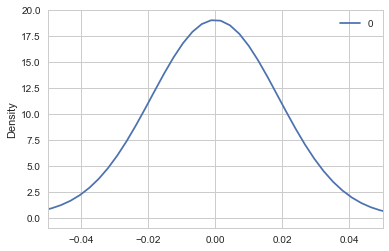

In [27]:
a = para_dict['Variable_39'].eval()
b = np.reshape(a,[-1])
data = b
df = pd.DataFrame(data)
df.plot(kind='density',xlim=(-0.05,0.05))

(432,)
Variable
(1728,)
Variable_1
(3024,)
Variable_2
(4320,)
Variable_3
(5616,)
Variable_4
(6912,)
Variable_5
(8208,)
Variable_6
(9504,)
Variable_7
(10800,)
Variable_8
(12096,)
Variable_9
(13392,)
Variable_10
(14688,)
Variable_11
(15984,)
Variable_12
(25600,)
Variable_13
(17280,)
Variable_14
(18576,)
Variable_15
(19872,)
Variable_16
(21168,)
Variable_17
(22464,)
Variable_18
(23760,)
Variable_19
(25056,)
Variable_20


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(26352,)
Variable_21
(27648,)
Variable_22
(28944,)
Variable_23
(30240,)
Variable_24
(31536,)
Variable_25
(92416,)
Variable_26
(32832,)
Variable_27
(34128,)
Variable_28
(35424,)
Variable_29
(36720,)
Variable_30
(38016,)
Variable_31
(39312,)
Variable_32
(40608,)
Variable_33
(41904,)
Variable_34
(43200,)
Variable_35
(44496,)
Variable_36
(45792,)
Variable_37
(47088,)
Variable_38
(4480,)
Variable_39
(10,)
Variable_40


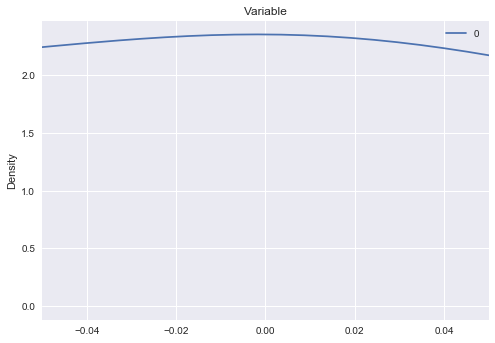

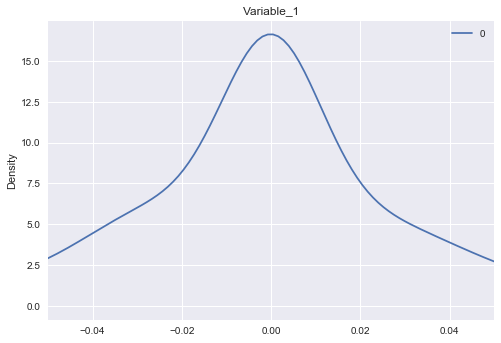

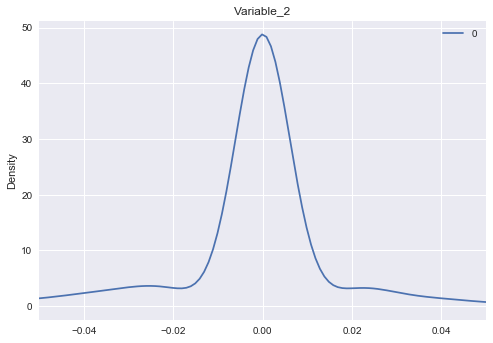

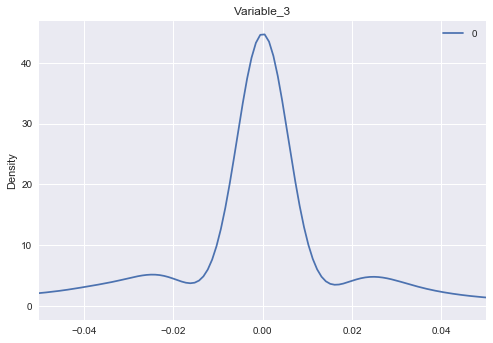

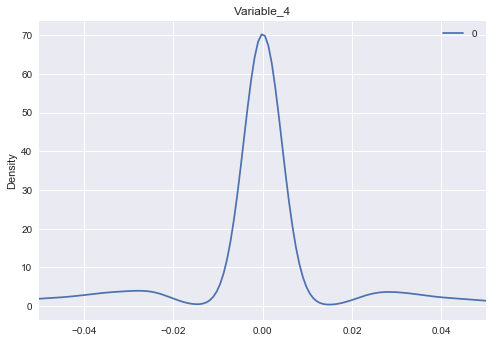

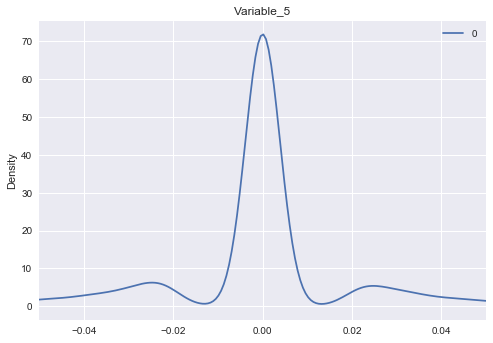

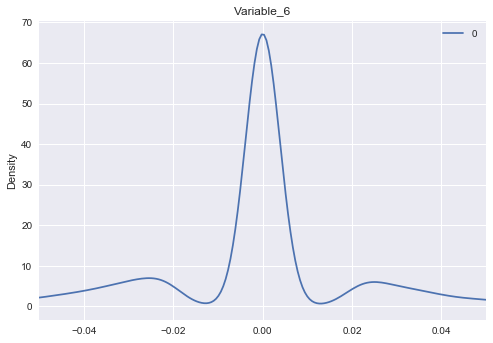

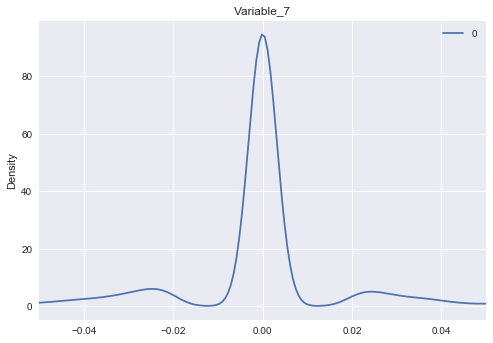

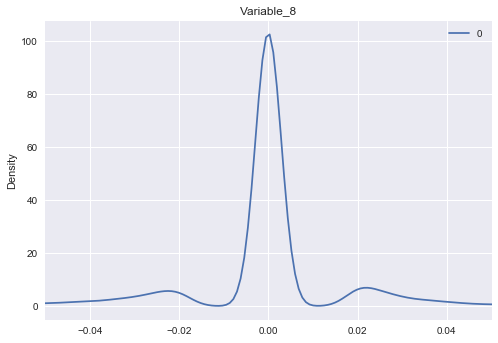

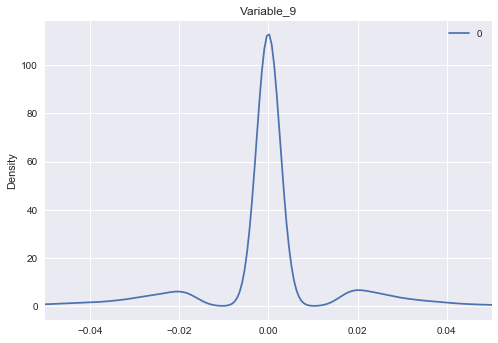

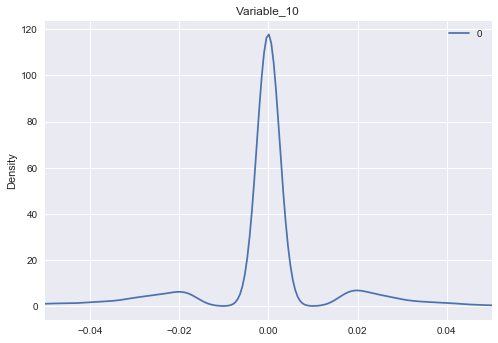

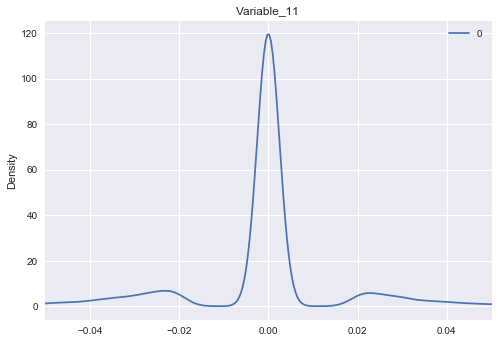

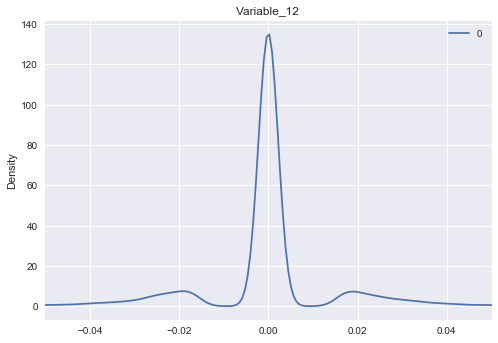

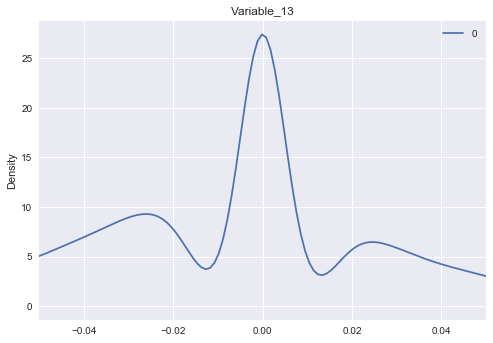

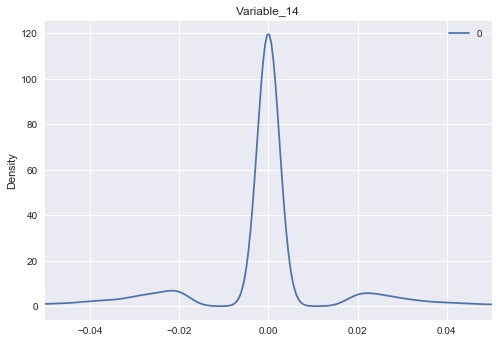

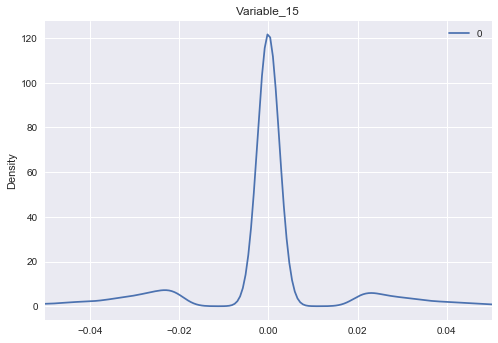

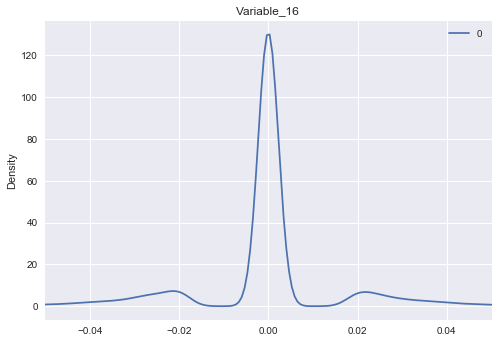

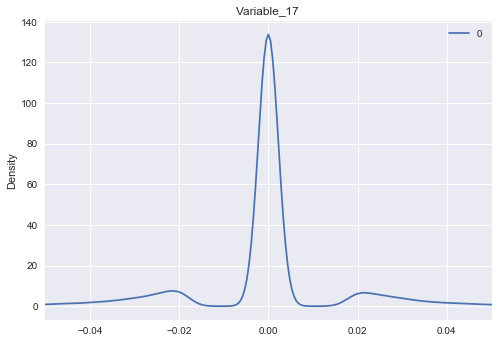

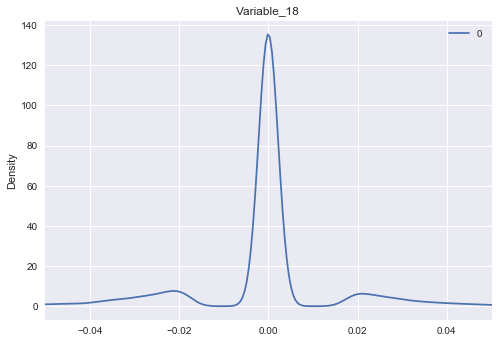

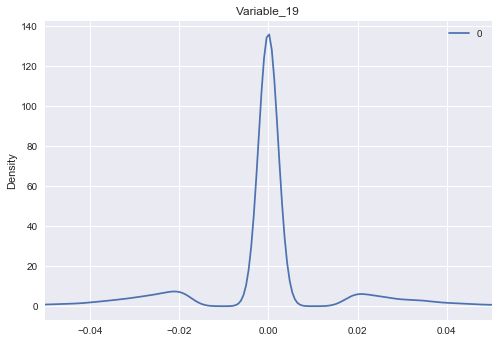

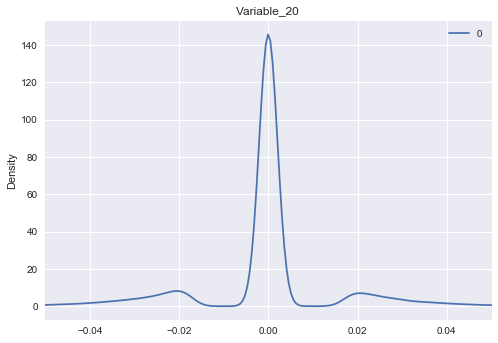

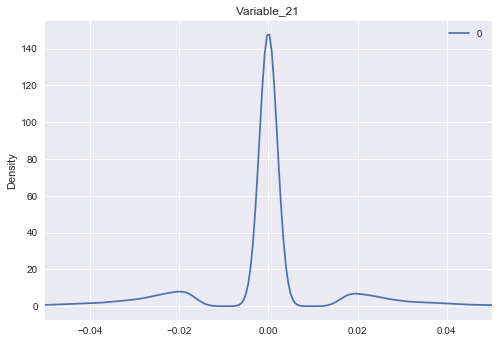

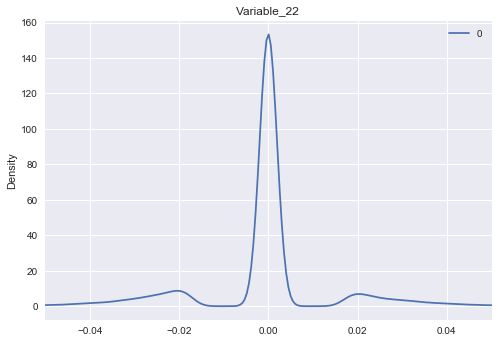

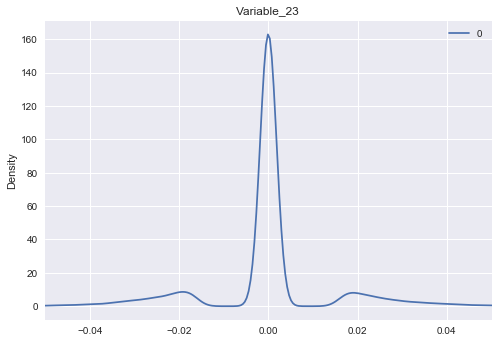

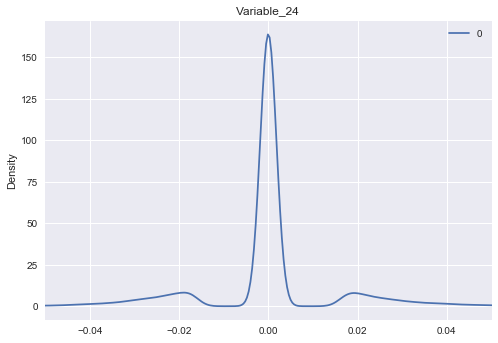

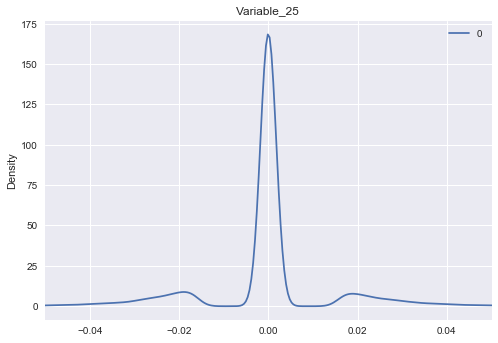

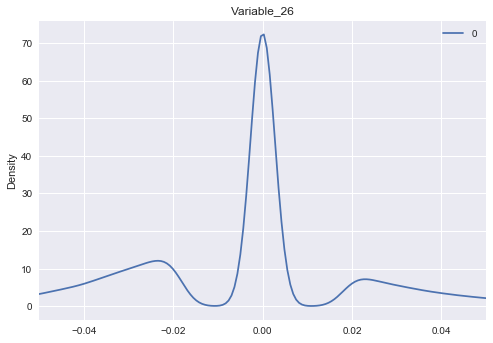

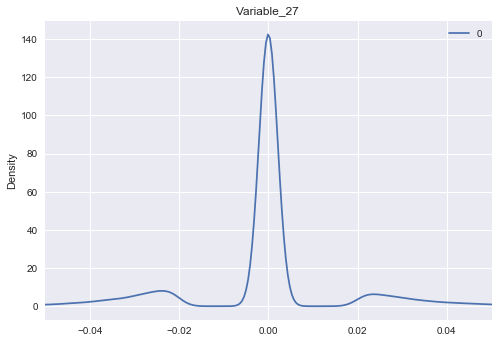

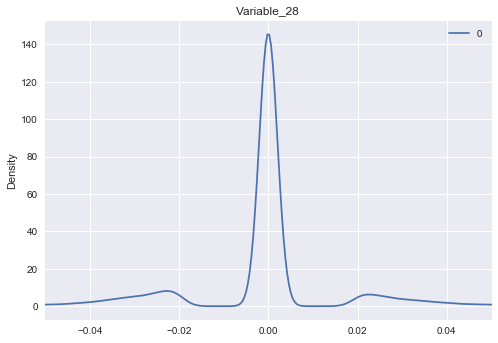

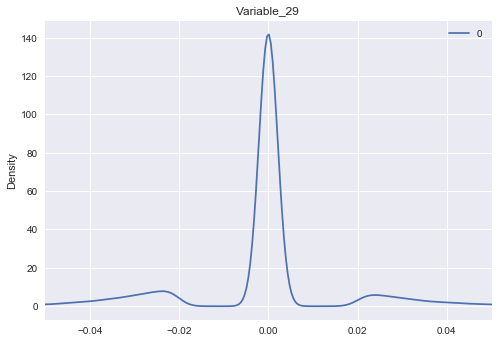

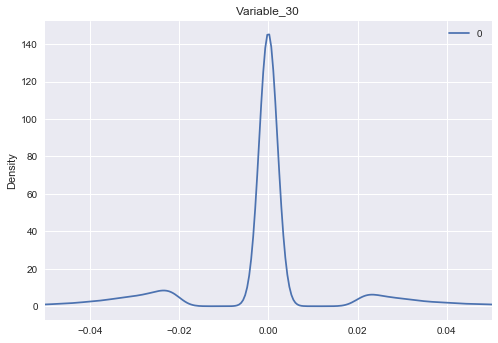

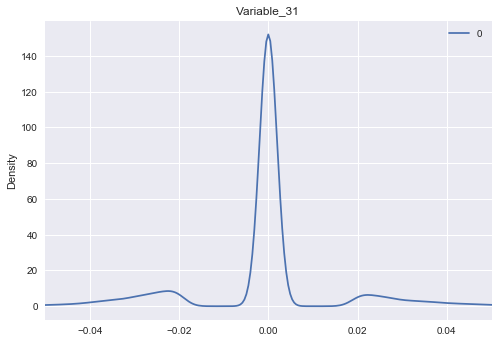

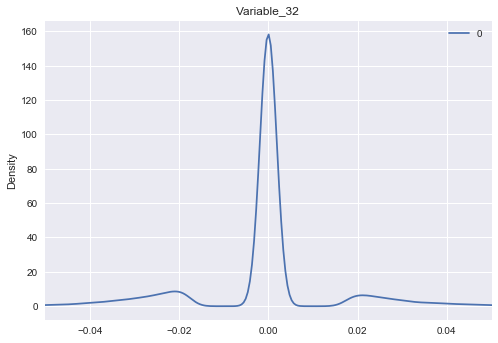

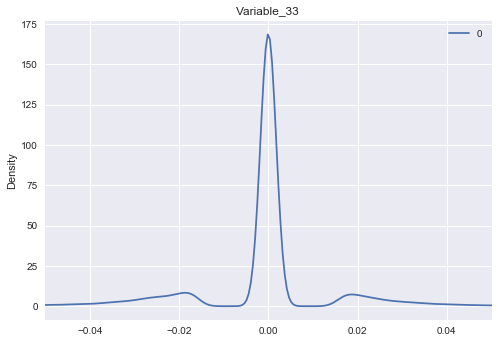

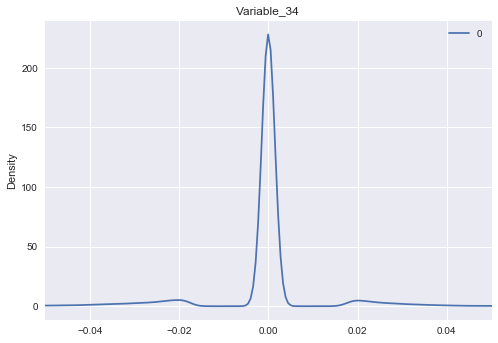

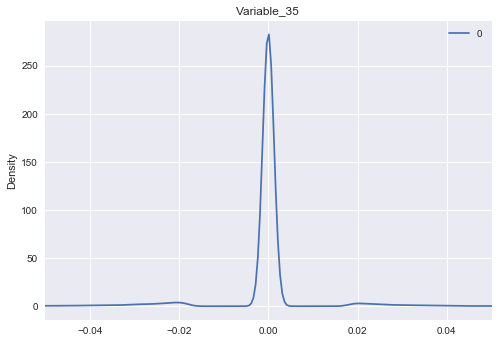

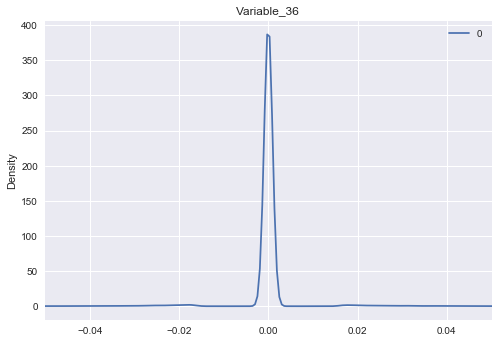

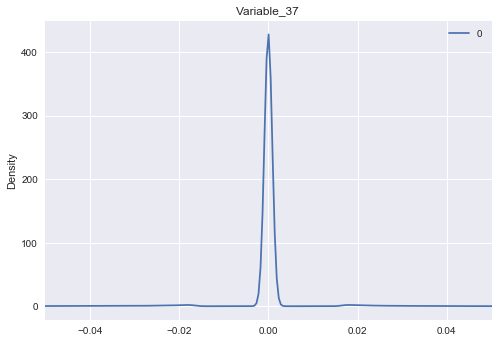

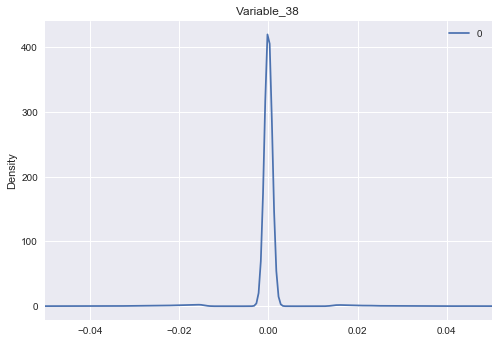

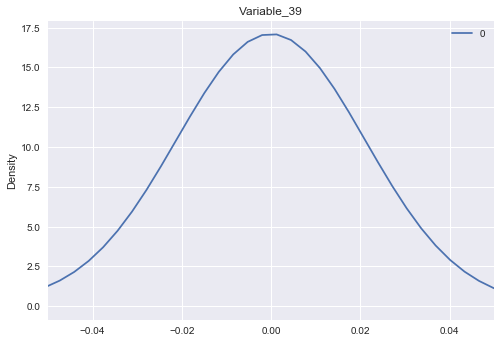

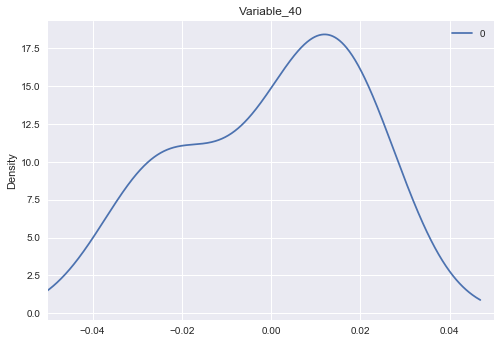

In [10]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
for i in para_dict.items():
    if 'Variable' in i[0]:
        a = para_dict[i[0]].eval()
        b = np.reshape(a,[-1])
        c = sum(b ==0)
        d = np.shape(b)
   #     e = np.percentile(b, 75)
       # print(c)
        print(d)
 #       print(e)
   #     print(int(np.log10(abs(e))))
        #print('percentage',c/d)
#         print(sum(b ==0))
#         plt.hist(b, range=[-0.4, 0.4]) 
#         plt.title(i[0]) 
#         plt.show()
        print(i[0])
        data = b
#         density = gaussian_kde(data)
#         xs = np.linspace(-0.4,0.4)
#         density.covariance_factor = lambda : .25
#         density._compute_covariance()
#         plt.plot(xs,density(xs))
#         plt.show()
  
        
#         sns.set_style('whitegrid')
#         sns.kdeplot(np.array(data), bw=0.5)


        data = b
        df = pd.DataFrame(data)
        df.plot(kind='density',xlim=(-0.05,0.05),title=i[0])

In [24]:
for i in para_dict.items():
    if 'Variable' in i[0]:
        a = para_dict[i[0]].eval()
        print(i[0])
        zeroele = len(a[abs(a)<0.04])
        total = len(np.reshape(a,[-1]))
        print(total - zeroele,total)
        print(zeroele/total)

Variable
338 432
0.2175925925925926
Variable_1
409 1728
0.7633101851851852
Variable_2
291 3024
0.9037698412698413
Variable_3
562 4320
0.8699074074074075
Variable_4
609 5616
0.8915598290598291
Variable_5
639 6912
0.9075520833333334
Variable_6
870 8208
0.8940058479532164
Variable_7
630 9504
0.9337121212121212
Variable_8
569 10800
0.9473148148148148
Variable_9
541 12096
0.9552744708994709
Variable_10
605 13392
0.9548237753882916
Variable_11
743 14688
0.9494144880174292
Variable_12
502 15984
0.9685935935935935
Variable_13
7276 25600
0.71578125
Variable_14
923 17280
0.9465856481481482
Variable_15
991 18576
0.946651593453919
Variable_16
855 19872
0.9569746376811594
Variable_17
914 21168
0.9568216175359032
Variable_18
918 22464
0.9591346153846154
Variable_19
982 23760
0.9586700336700337
Variable_20
864 25056
0.9655172413793104
Variable_21
924 26352
0.964936247723133
Variable_22
864 27648
0.96875
Variable_23
730 28944
0.974778883360973
Variable_24
777 30240
0.9743055555555555
Variable_25
753 3

(432,)
Variable
(16,)
BatchNorm/beta
(16,)
BatchNorm/gamma
(16,)
BatchNorm/moving_mean
(16,)
BatchNorm/moving_variance
(1728,)
Variable_1
(28,)
BatchNorm_1/beta
(28,)
BatchNorm_1/gamma
(28,)
BatchNorm_1/moving_mean
(28,)
BatchNorm_1/moving_variance
(3024,)
Variable_2
(40,)
BatchNorm_2/beta
(40,)
BatchNorm_2/gamma
(40,)
BatchNorm_2/moving_mean
(40,)
BatchNorm_2/moving_variance
(4320,)
Variable_3
(52,)
BatchNorm_3/beta
(52,)
BatchNorm_3/gamma
(52,)
BatchNorm_3/moving_mean
(52,)
BatchNorm_3/moving_variance
(5616,)
Variable_4


D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(64,)
BatchNorm_4/beta
(64,)
BatchNorm_4/gamma
(64,)
BatchNorm_4/moving_mean
(64,)
BatchNorm_4/moving_variance
(6912,)
Variable_5
(76,)
BatchNorm_5/beta
(76,)
BatchNorm_5/gamma
(76,)
BatchNorm_5/moving_mean
(76,)
BatchNorm_5/moving_variance
(8208,)
Variable_6
(88,)
BatchNorm_6/beta
(88,)
BatchNorm_6/gamma
(88,)
BatchNorm_6/moving_mean
(88,)
BatchNorm_6/moving_variance
(9504,)
Variable_7
(100,)
BatchNorm_7/beta
(100,)
BatchNorm_7/gamma
(100,)
BatchNorm_7/moving_mean
(100,)
BatchNorm_7/moving_variance
(10800,)
Variable_8
(112,)
BatchNorm_8/beta
(112,)
BatchNorm_8/gamma
(112,)
BatchNorm_8/moving_mean
(112,)
BatchNorm_8/moving_variance
(12096,)
Variable_9
(124,)
BatchNorm_9/beta
(124,)
BatchNorm_9/gamma
(124,)
BatchNorm_9/moving_mean
(124,)
BatchNorm_9/moving_variance
(13392,)
Variable_10
(136,)
BatchNorm_10/beta
(136,)
BatchNorm_10/gamma
(136,)
BatchNorm_10/moving_mean
(136,)
BatchNorm_10/moving_variance
(14688,)
Variable_11
(148,)
BatchNorm_11/beta
(148,)
BatchNorm_11/gamma
(148,)
BatchN

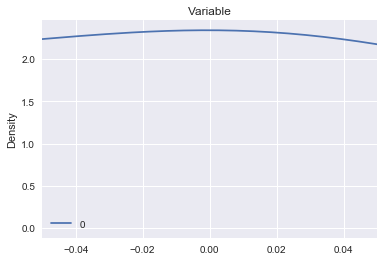

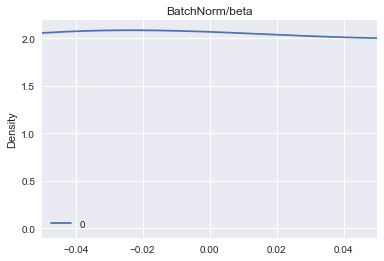

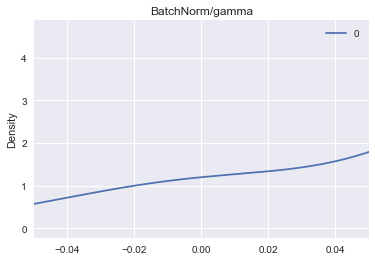

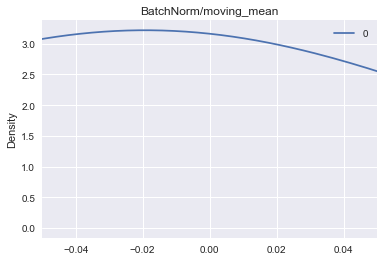

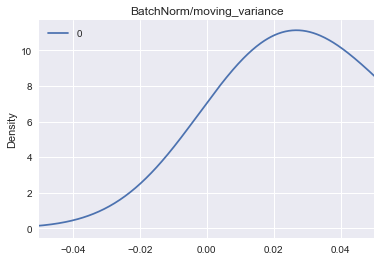

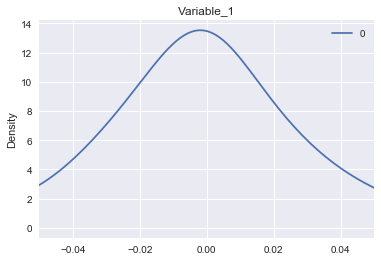

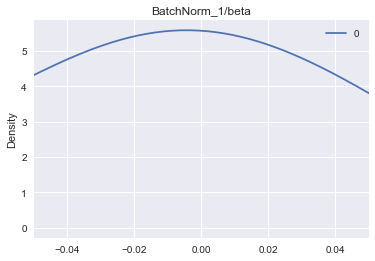

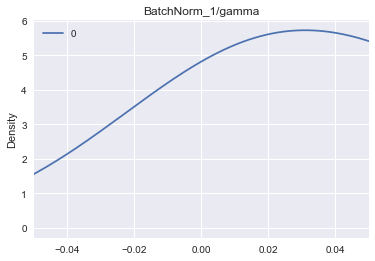

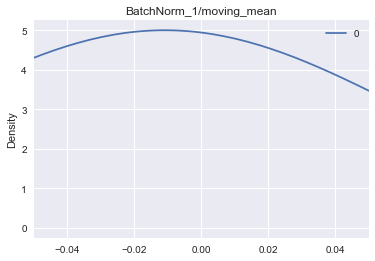

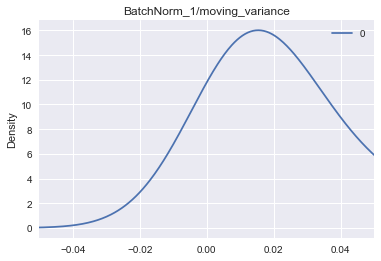

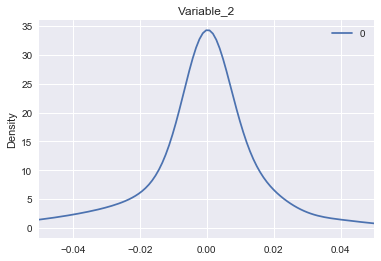

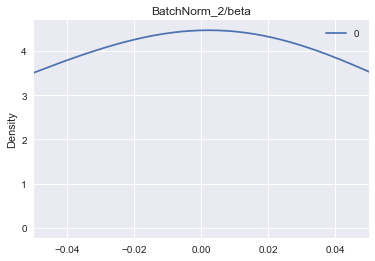

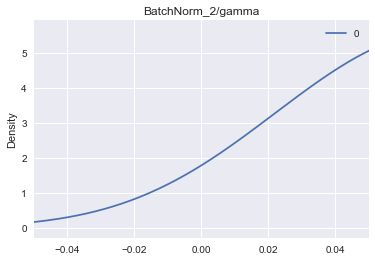

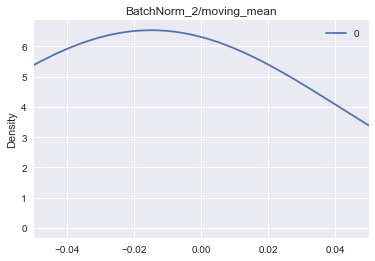

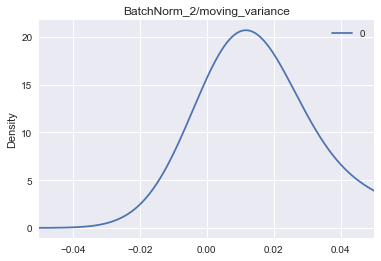

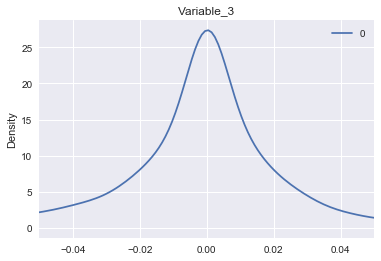

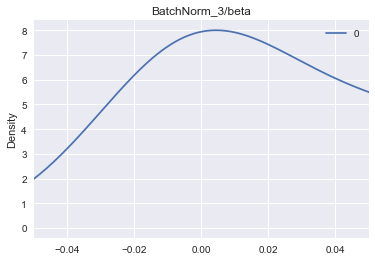

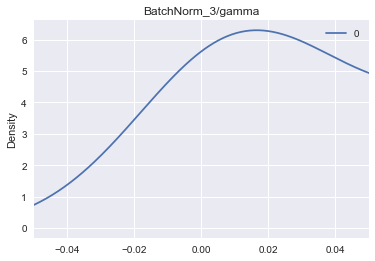

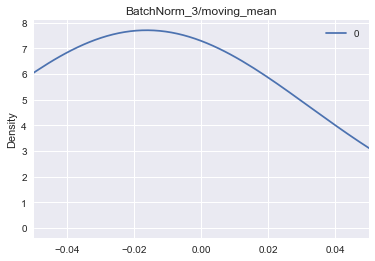

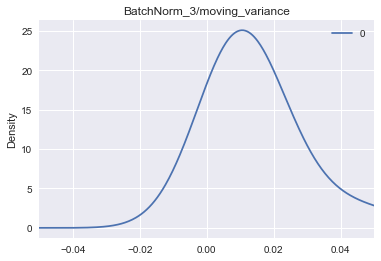

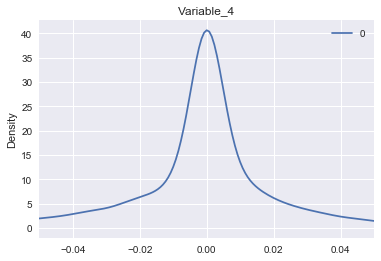

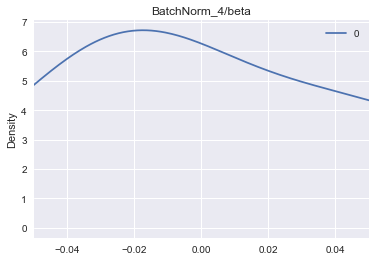

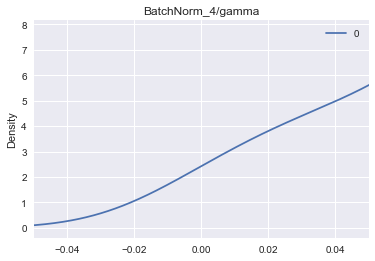

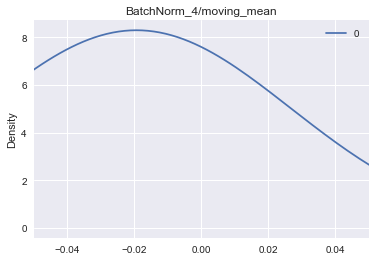

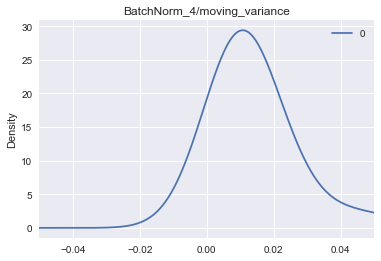

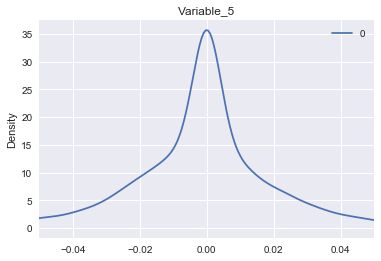

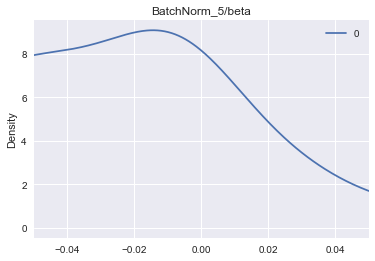

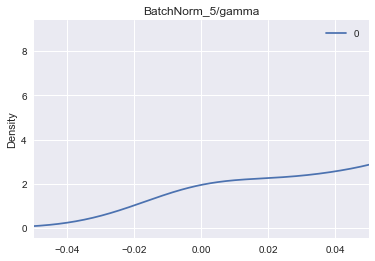

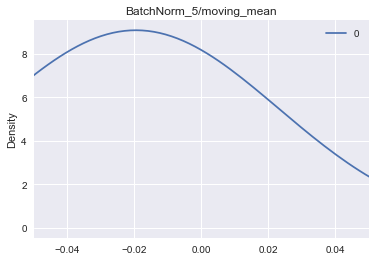

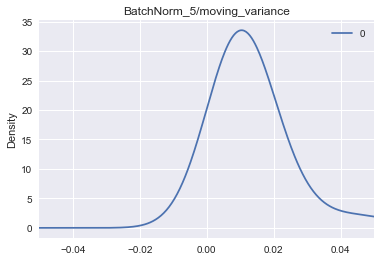

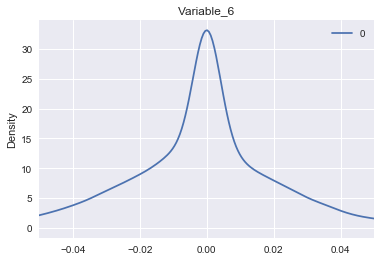

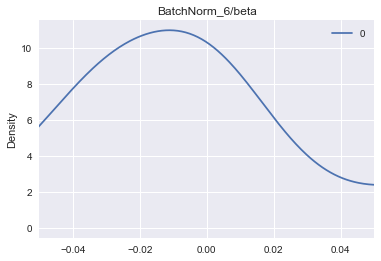

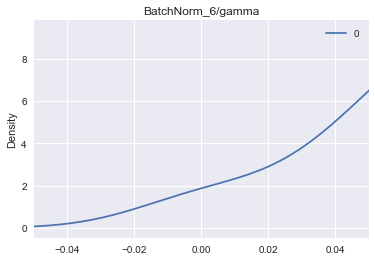

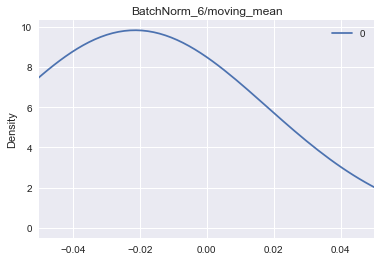

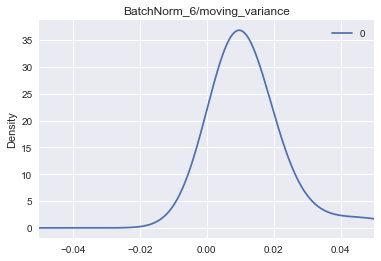

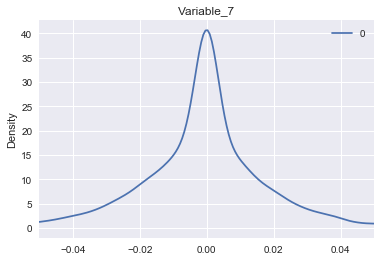

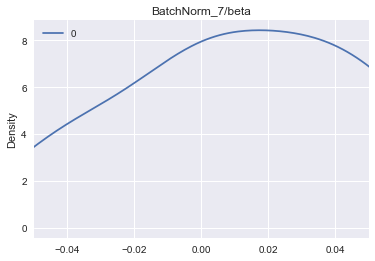

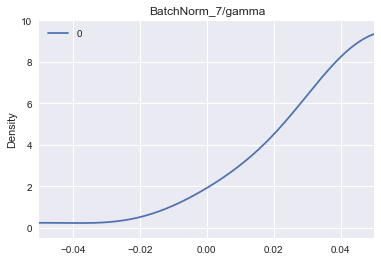

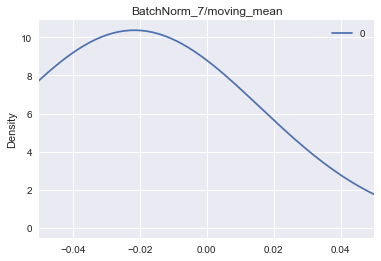

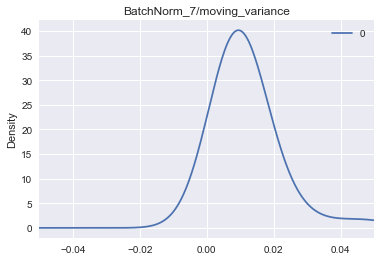

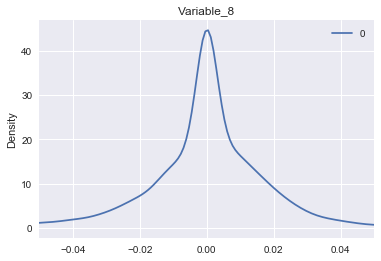

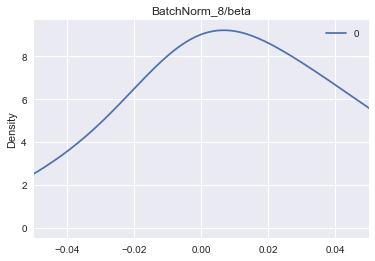

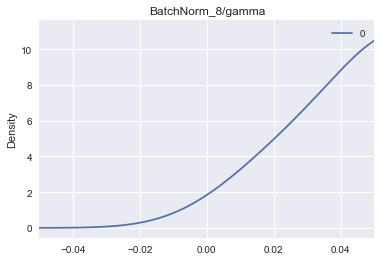

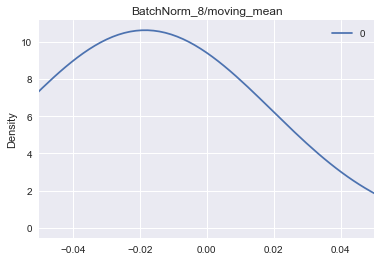

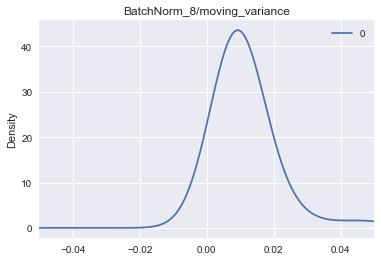

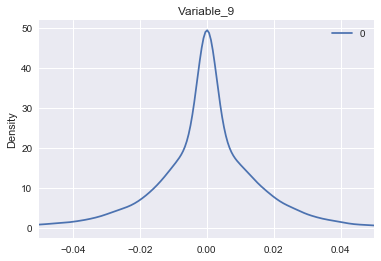

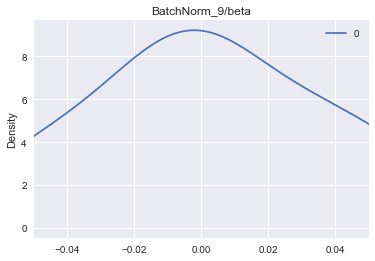

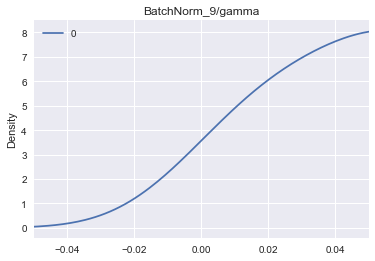

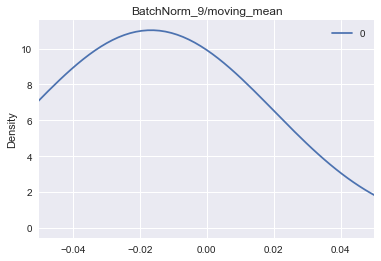

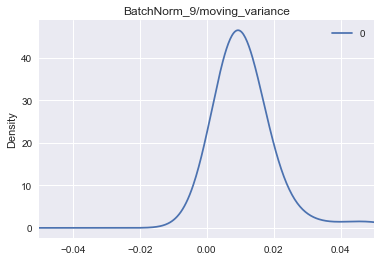

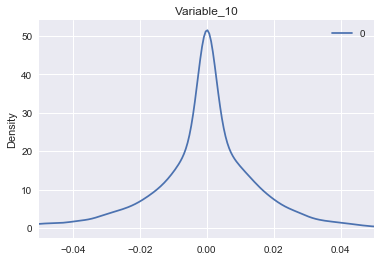

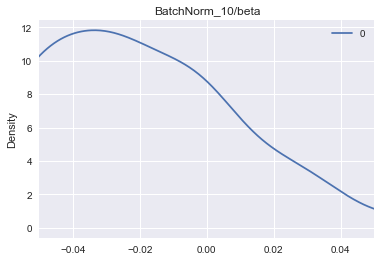

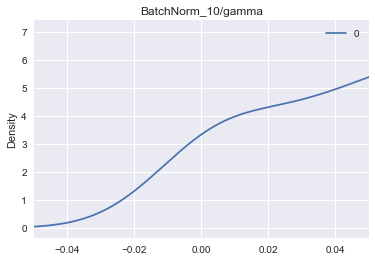

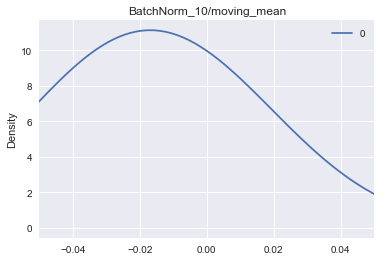

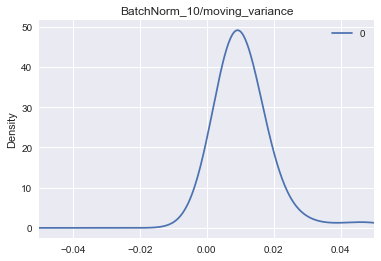

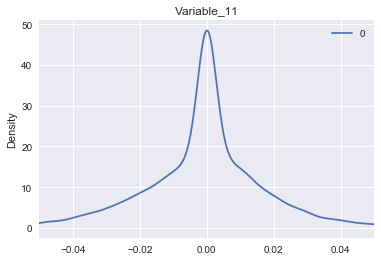

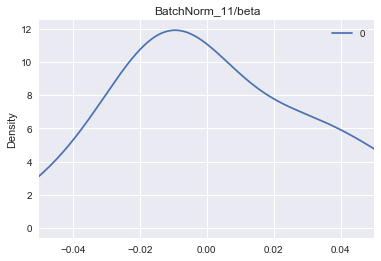

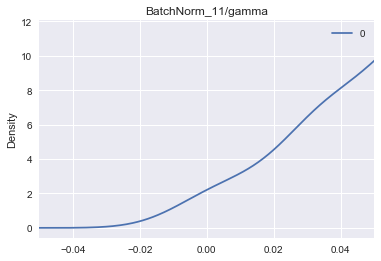

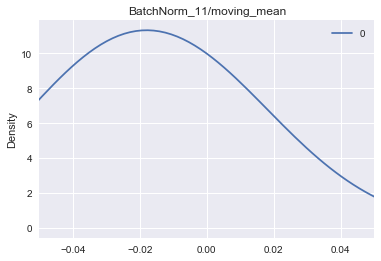

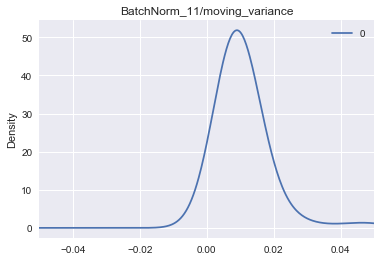

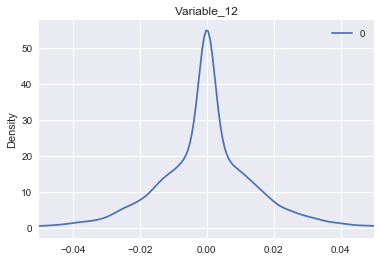

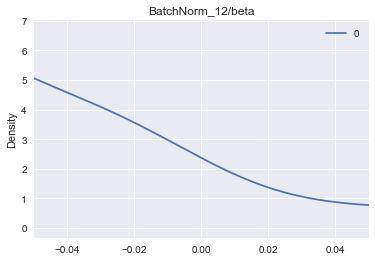

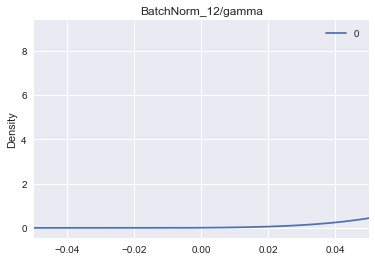

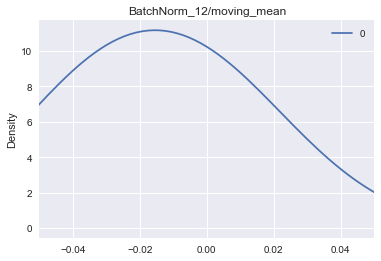

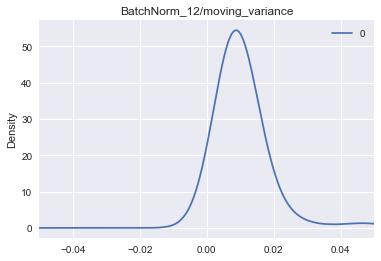

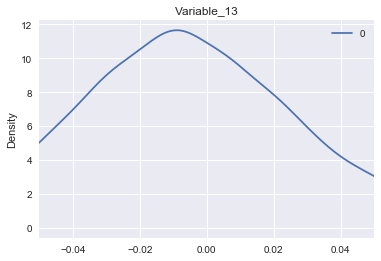

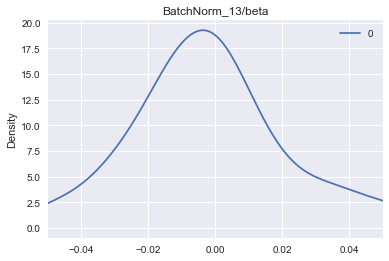

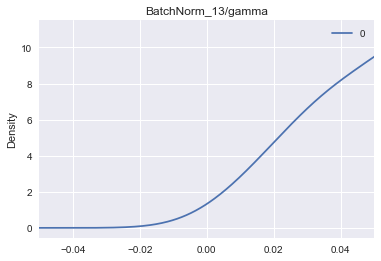

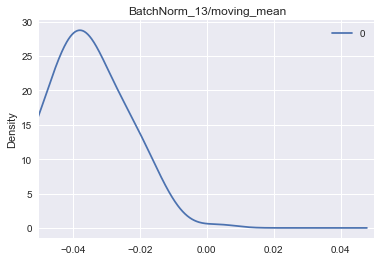

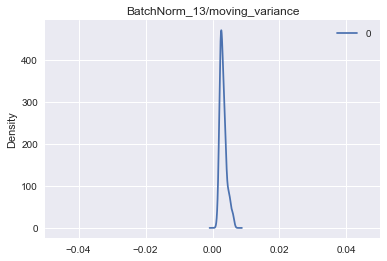

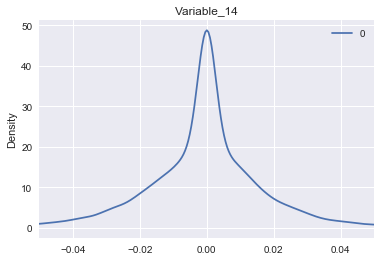

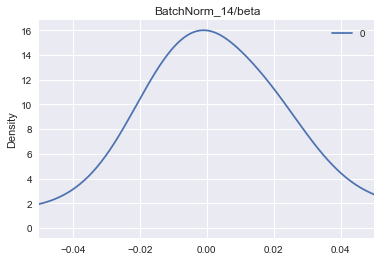

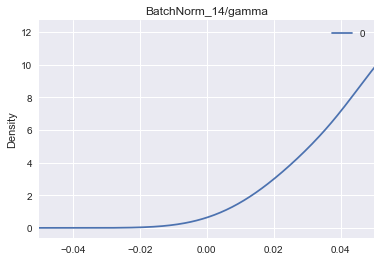

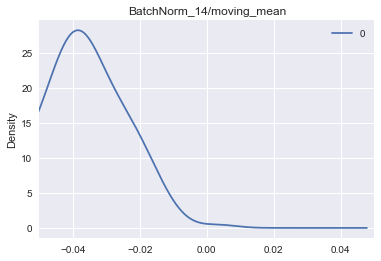

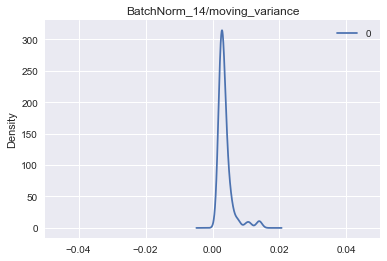

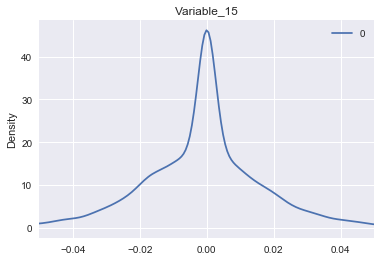

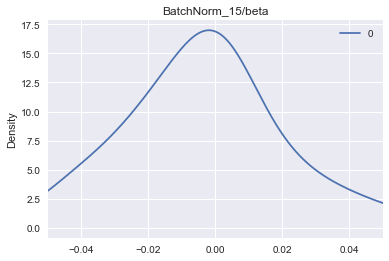

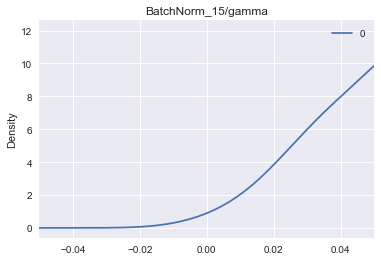

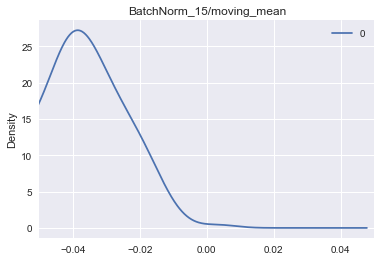

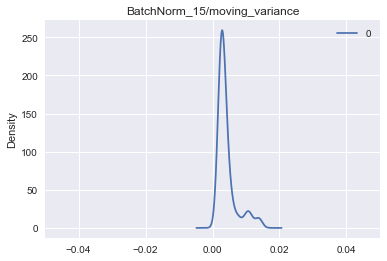

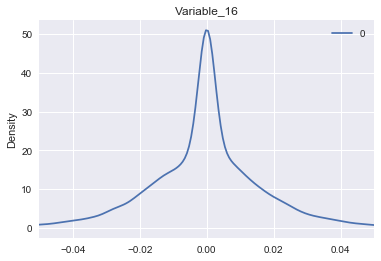

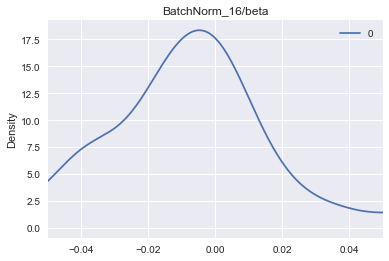

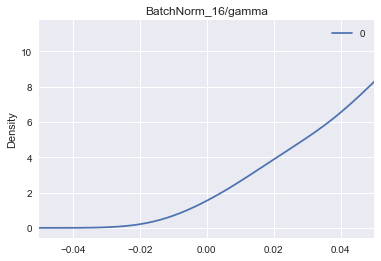

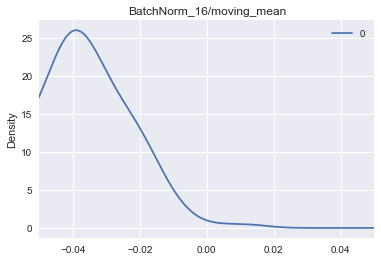

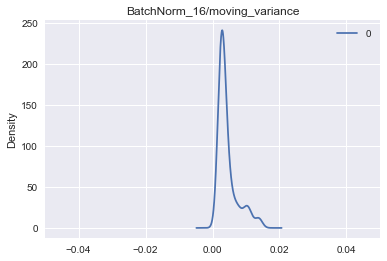

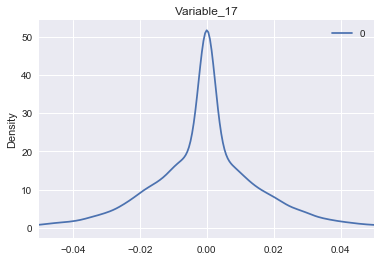

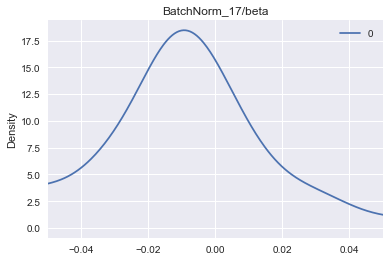

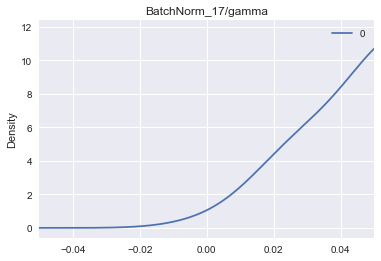

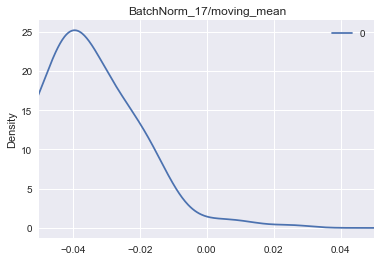

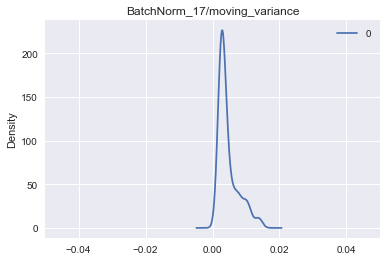

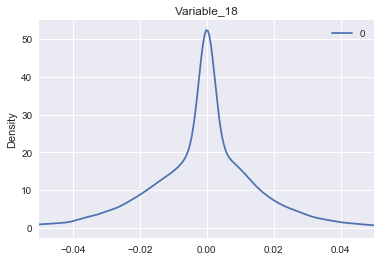

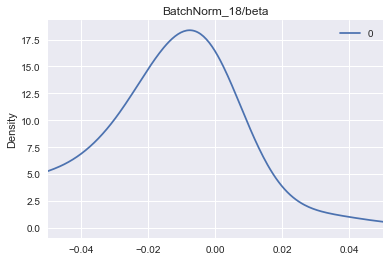

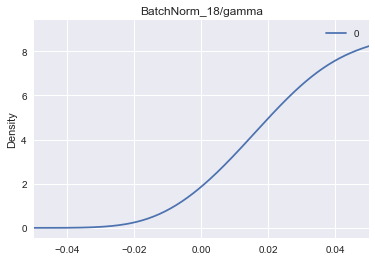

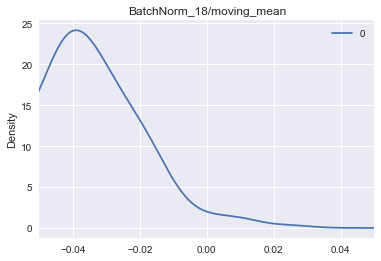

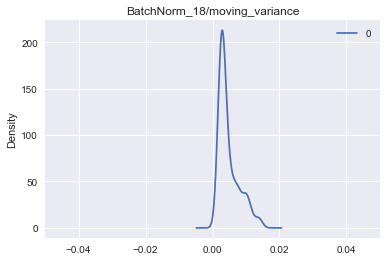

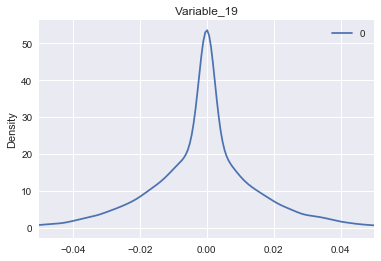

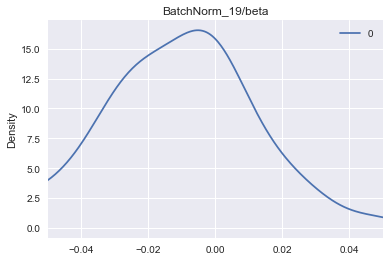

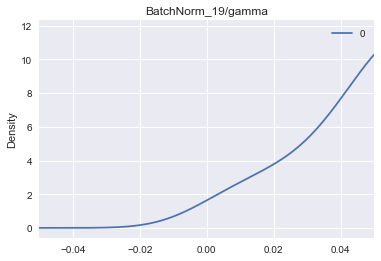

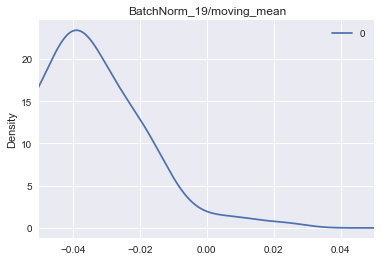

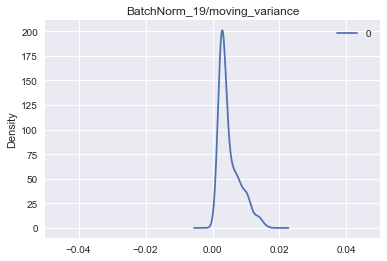

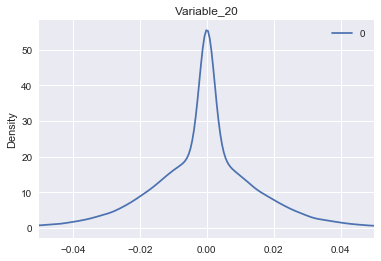

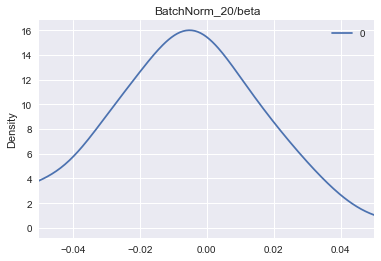

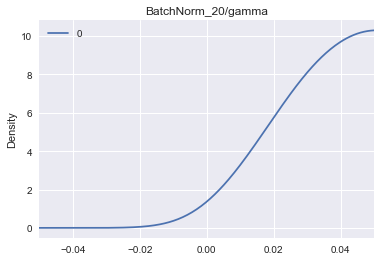

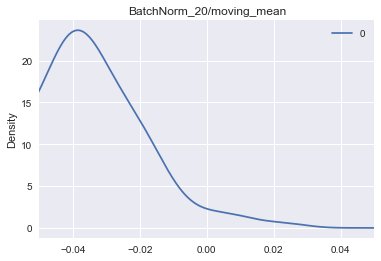

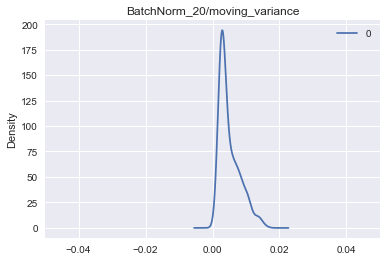

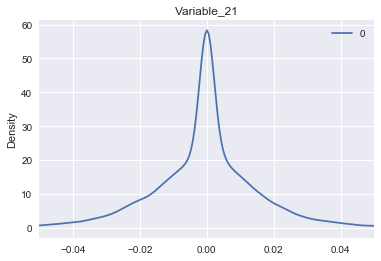

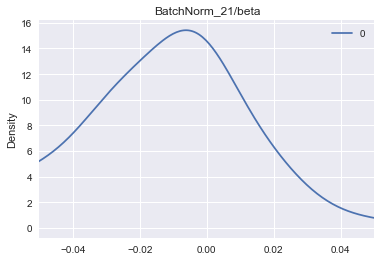

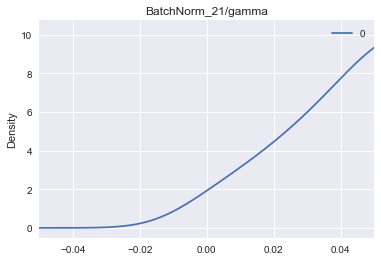

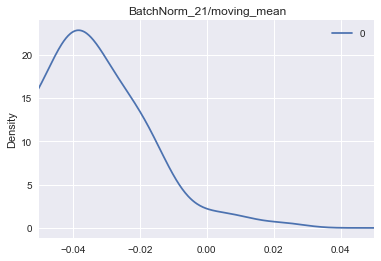

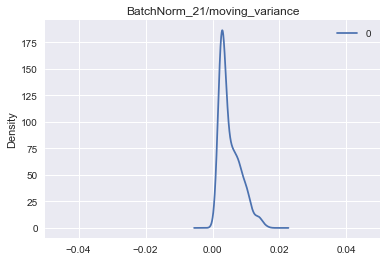

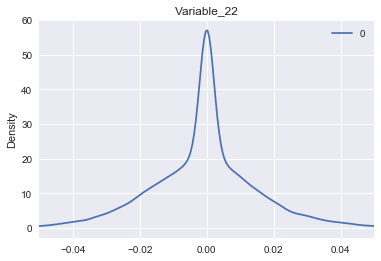

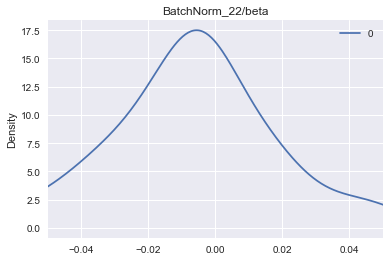

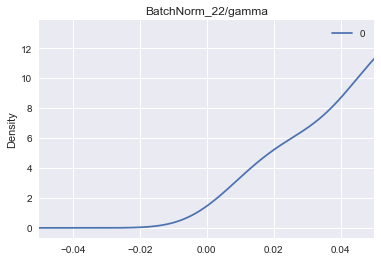

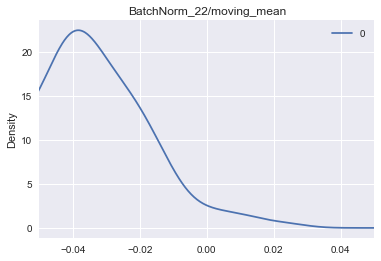

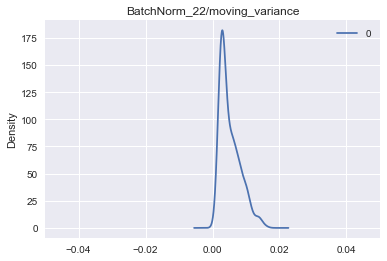

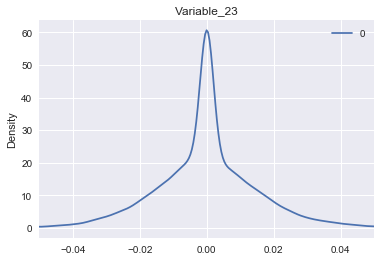

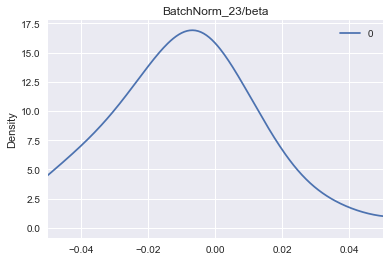

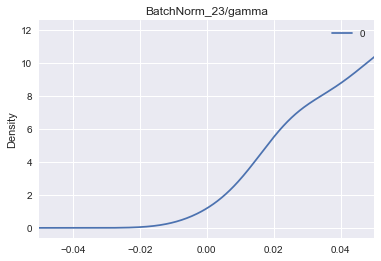

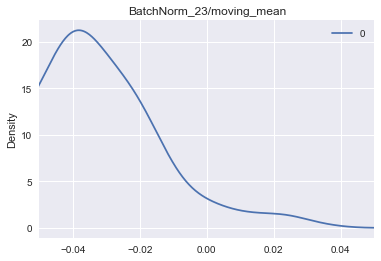

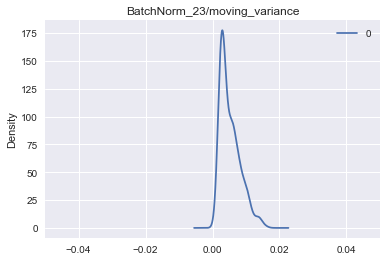

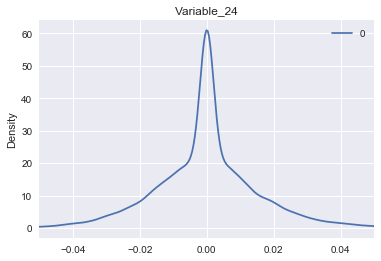

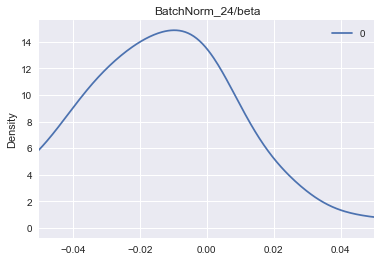

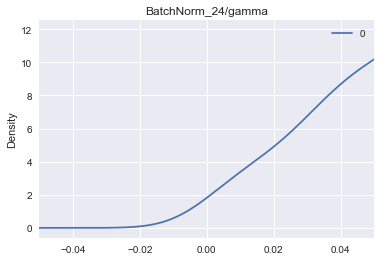

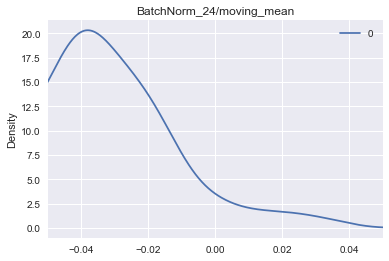

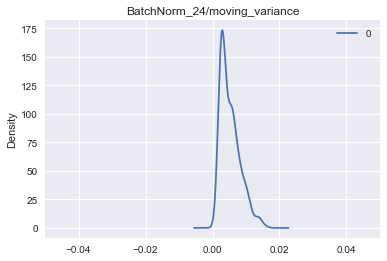

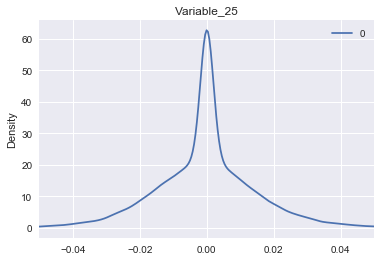

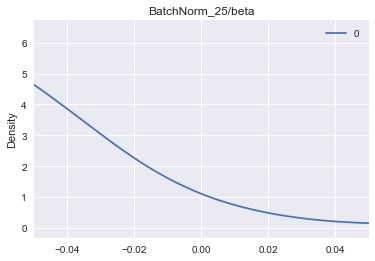

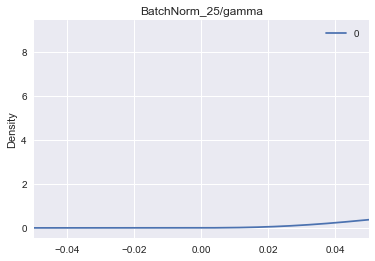

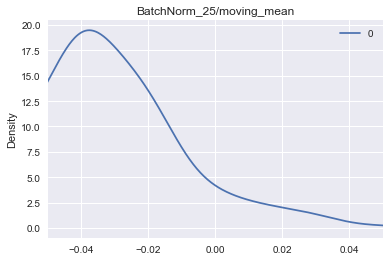

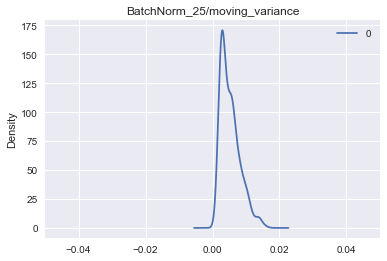

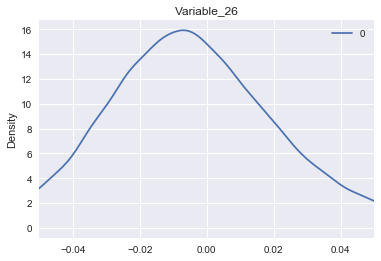

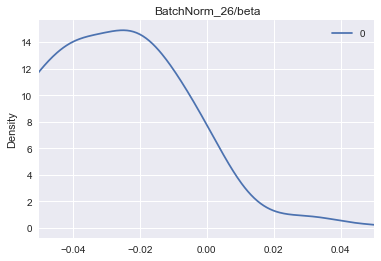

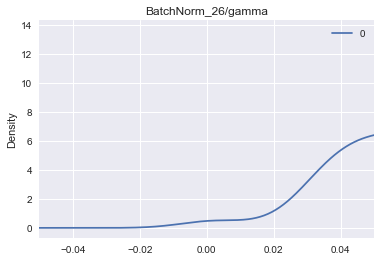

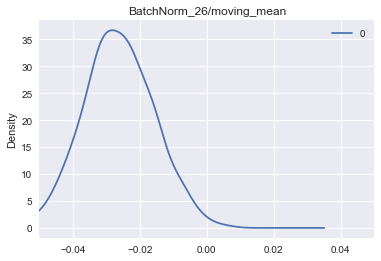

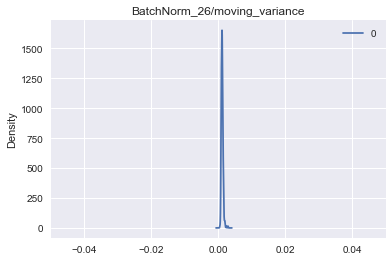

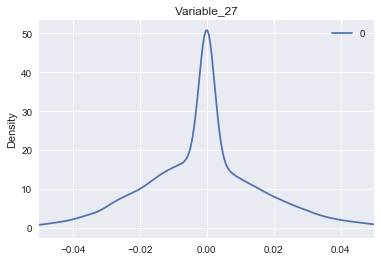

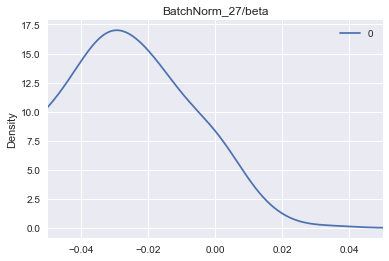

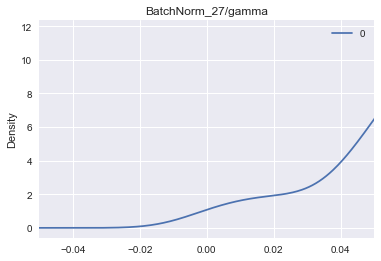

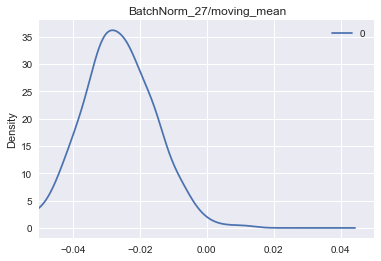

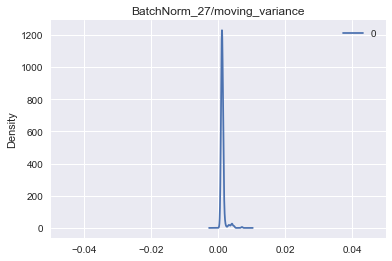

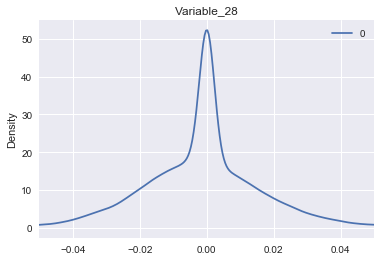

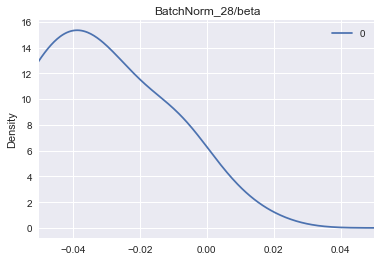

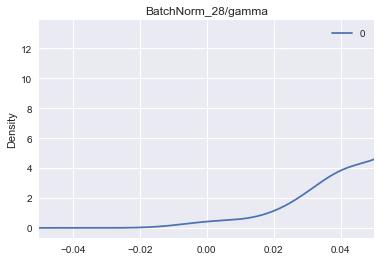

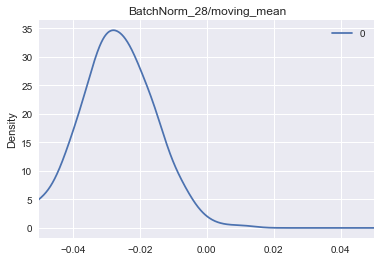

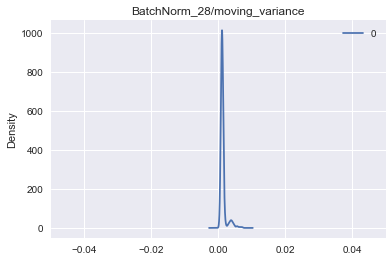

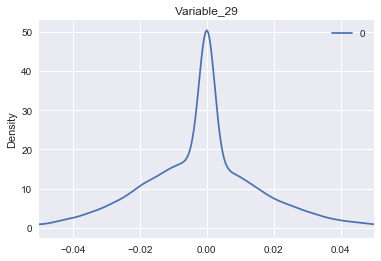

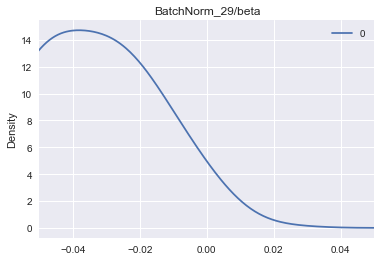

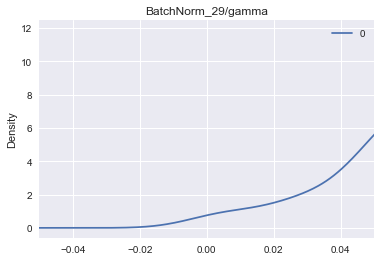

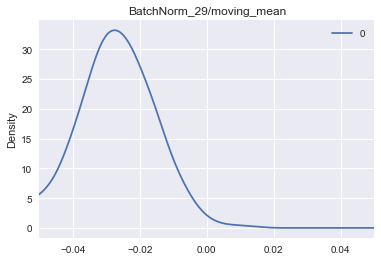

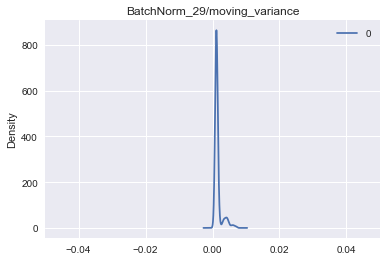

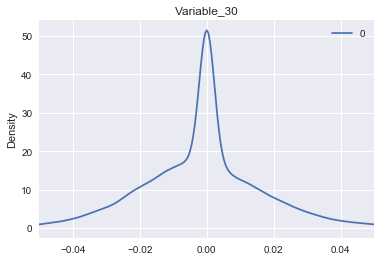

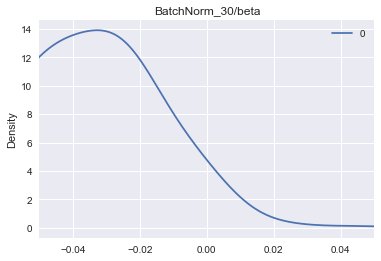

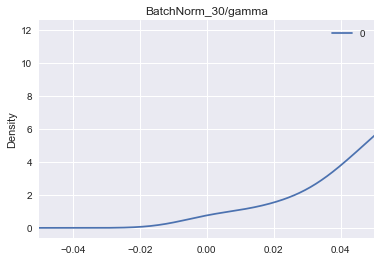

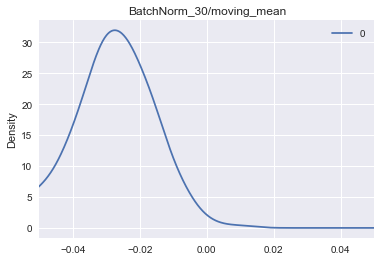

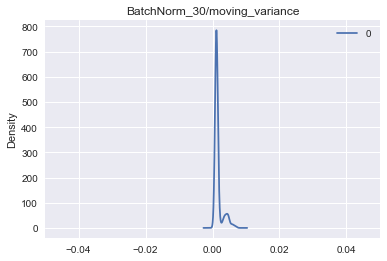

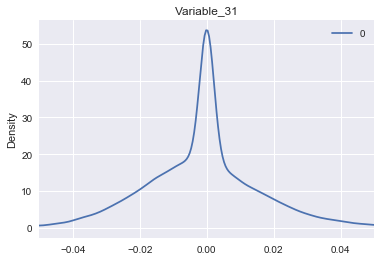

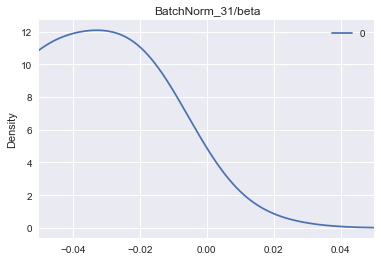

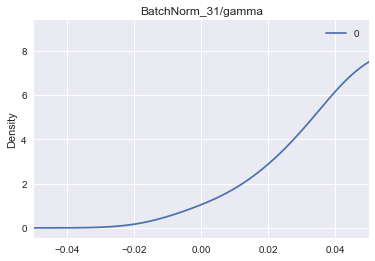

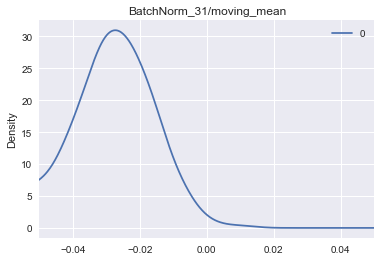

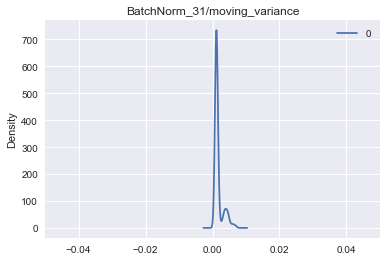

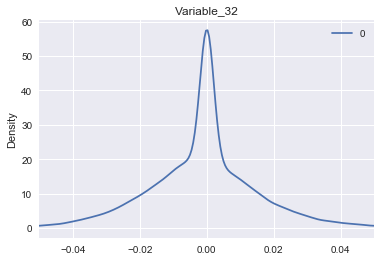

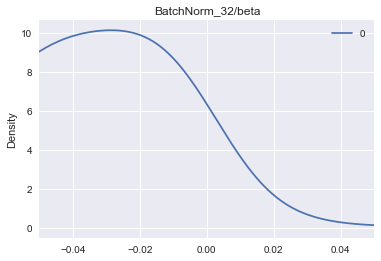

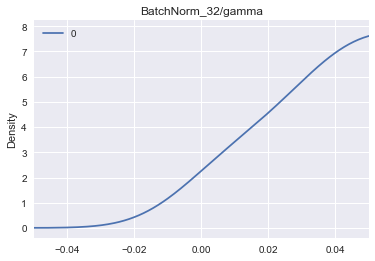

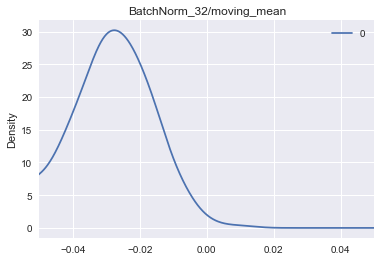

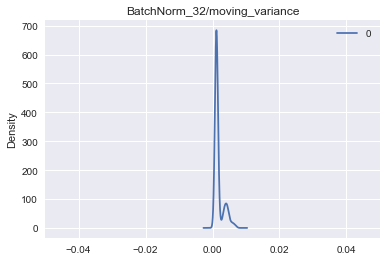

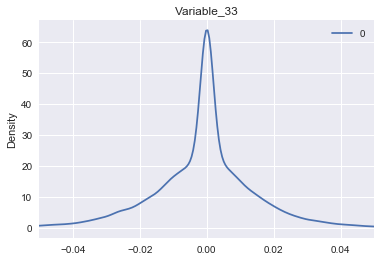

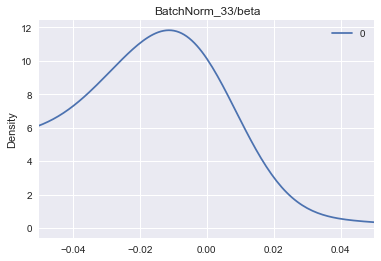

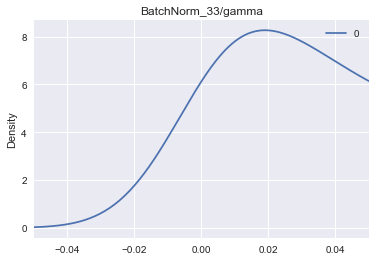

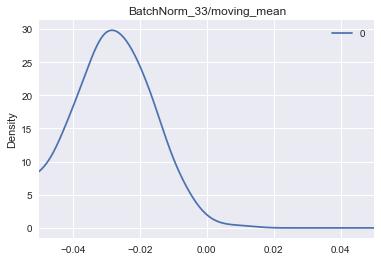

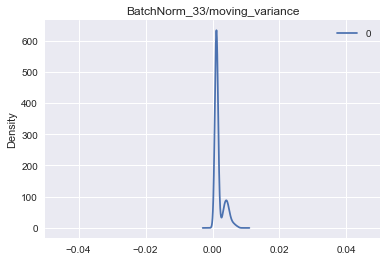

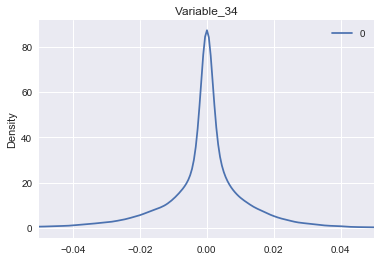

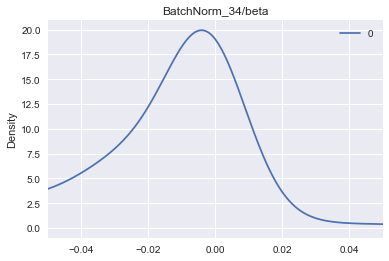

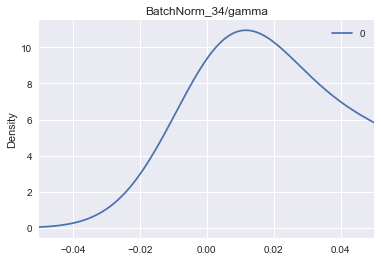

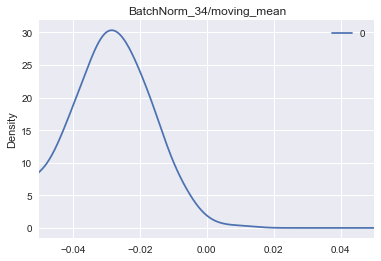

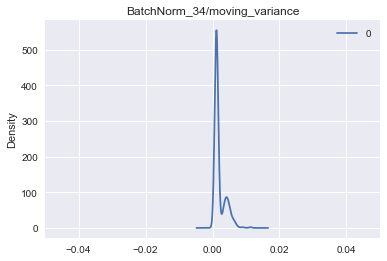

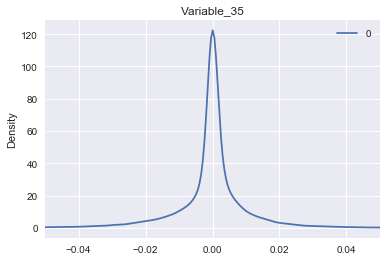

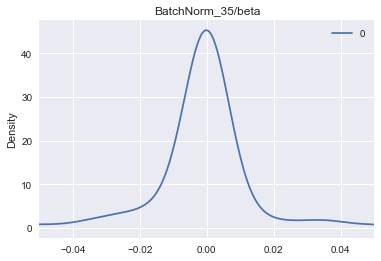

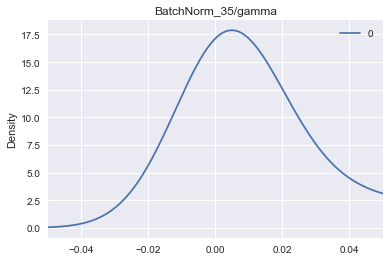

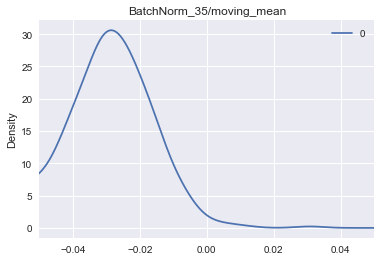

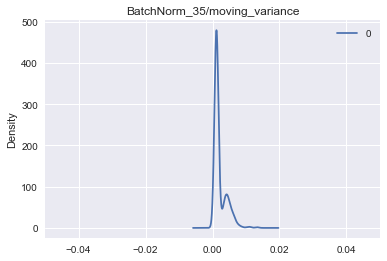

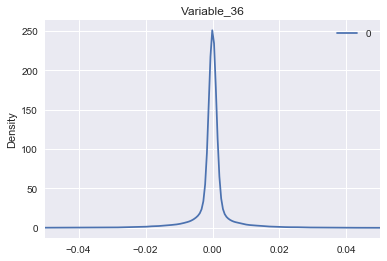

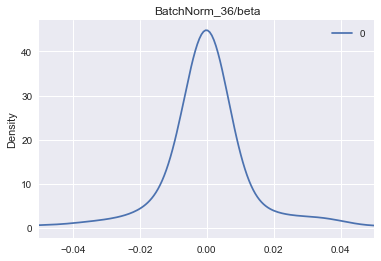

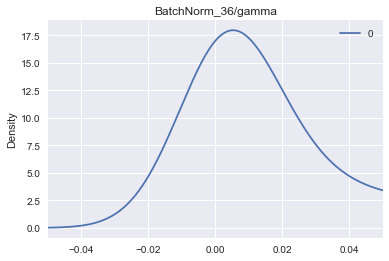

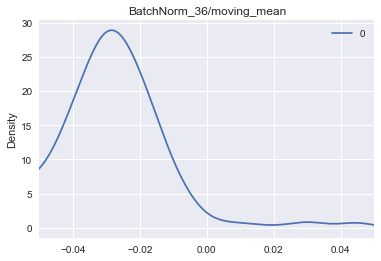

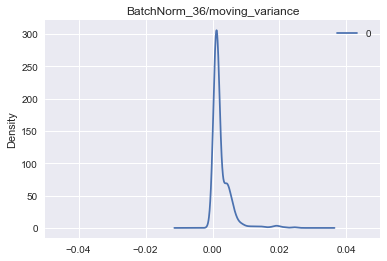

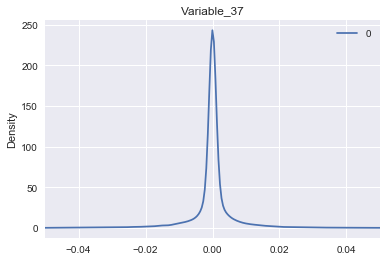

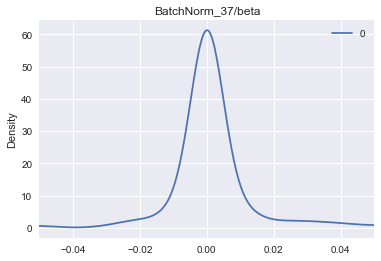

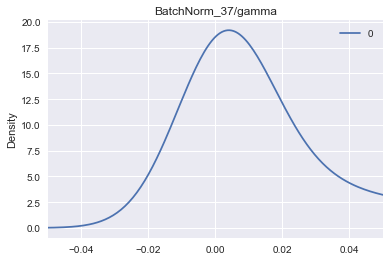

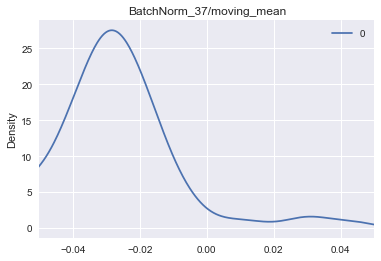

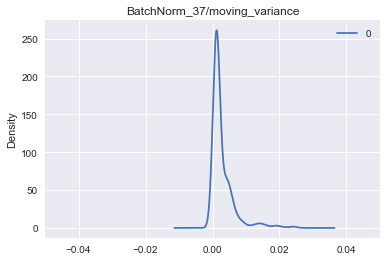

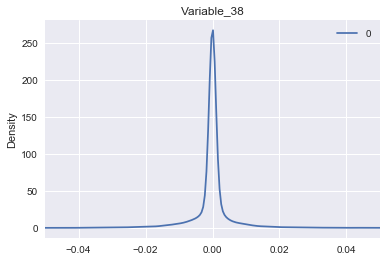

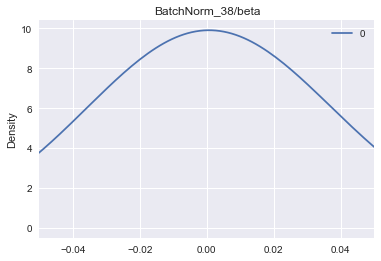

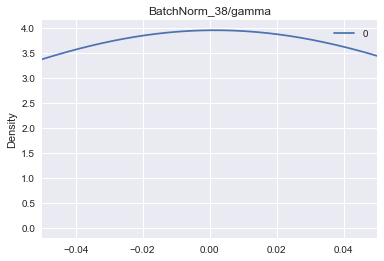

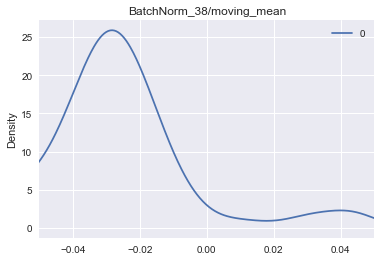

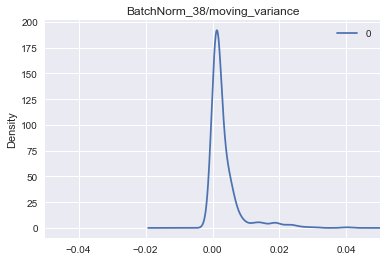

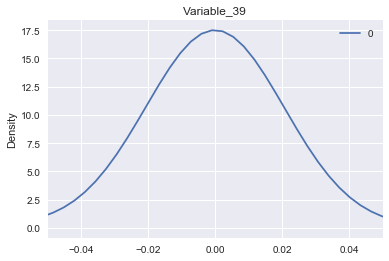

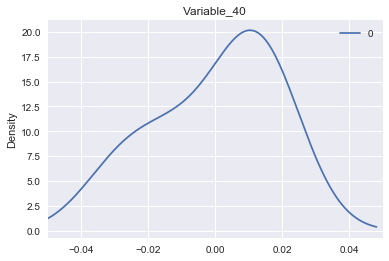

In [16]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
for i in para_dict.items():
    #if 'Variable' in i[0]:
        a = para_dict[i[0]].eval()
        b = np.reshape(a,[-1])
        c = sum(b ==0)
        d = np.shape(b)
   #     e = np.percentile(b, 75)
       # print(c)
        print(d)
 #       print(e)
   #     print(int(np.log10(abs(e))))
        #print('percentage',c/d)
#         print(sum(b ==0))
#         plt.hist(b, range=[-0.4, 0.4]) 
#         plt.title(i[0]) 
#         plt.show()
        print(i[0])
        data = b
#         density = gaussian_kde(data)
#         xs = np.linspace(-0.4,0.4)
#         density.covariance_factor = lambda : .25
#         density._compute_covariance()
#         plt.plot(xs,density(xs))
#         plt.show()
  
        
#         sns.set_style('whitegrid')
#         sns.kdeplot(np.array(data), bw=0.5)


        data = b
        df = pd.DataFrame(data)
        df.plot(kind='density',xlim=(-0.05,0.05),title=i[0])

In [45]:
a = parm_dict['Variable_39'].eval()
b = np.reshape(a,[-1])
print(sum(b <=0.00001))
print(np.shape(b))
print('percentage',a/b)

(4480,)

In [27]:
parm_dict={}
for k in tf.trainable_variables():
    parm_dict[k.name] = k
with tf.Session(graph=graph) as session:
    saver= tf.train.Saver(parm_dict) 
    saver.restore(session,"weights_densenet")

Variable:0
BatchNorm/beta:0
BatchNorm/gamma:0
Variable_1:0
BatchNorm_1/beta:0
BatchNorm_1/gamma:0
Variable_2:0
BatchNorm_2/beta:0
BatchNorm_2/gamma:0
Variable_3:0
BatchNorm_3/beta:0
BatchNorm_3/gamma:0
Variable_4:0
BatchNorm_4/beta:0
BatchNorm_4/gamma:0
Variable_5:0
BatchNorm_5/beta:0
BatchNorm_5/gamma:0
Variable_6:0
BatchNorm_6/beta:0
BatchNorm_6/gamma:0
Variable_7:0
BatchNorm_7/beta:0
BatchNorm_7/gamma:0
Variable_8:0
BatchNorm_8/beta:0
BatchNorm_8/gamma:0
Variable_9:0
BatchNorm_9/beta:0
BatchNorm_9/gamma:0
Variable_10:0
BatchNorm_10/beta:0
BatchNorm_10/gamma:0
Variable_11:0
BatchNorm_11/beta:0
BatchNorm_11/gamma:0
Variable_12:0
BatchNorm_12/beta:0
BatchNorm_12/gamma:0
Variable_13:0
BatchNorm_13/beta:0
BatchNorm_13/gamma:0
Variable_14:0
BatchNorm_14/beta:0
BatchNorm_14/gamma:0
Variable_15:0
BatchNorm_15/beta:0
BatchNorm_15/gamma:0
Variable_16:0
BatchNorm_16/beta:0
BatchNorm_16/gamma:0
Variable_17:0
BatchNorm_17/beta:0
BatchNorm_17/gamma:0
Variable_18:0
BatchNorm_18/beta:0
BatchNorm_18